# Instalación de Dependencias e Importación de Librerías
Instalación de PyWavelets, fCWT y otras dependencias necesarias. Importación de todas las bibliotecas requeridas para procesamiento de señales, visualización y aprendizaje profundo.

In [2]:
# Instalación de dependencias necesarias
!pip install PyWavelets
!git clone https://github.com/fastlib/fCWT.git
!pip install fCWT
!apt-get update
!apt-get install libfftw3-single3 -y
!pip install opencv-python

# Importación de bibliotecas necesarias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random
import h5py
import cv2
import pywt
import fcwt
import scipy
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm
from IPython.display import display

# Importar la clase WaveletDenoising (debe estar en un archivo denoising.py en el path)
from denoising import WaveletDenoising

# Montar Google Drive (para Colab)
from google.colab import drive
drive.mount('/content/drive')

# Configuraciones globales para visualización
plt.style.use('seaborn-v0_8-whitegrid')

fatal: destination path 'fCWT' already exists and is not an empty directory.
Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry miss

# Carga y Visualización de Datos
Carga de los datos de acelerómetro desde Google Drive, con opciones para clasificación binaria o multiclase. Visualización de las señales originales.

Data Directory: /content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched
Sample Rate: 25600 Hz
Classification Mode: five_classes
Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


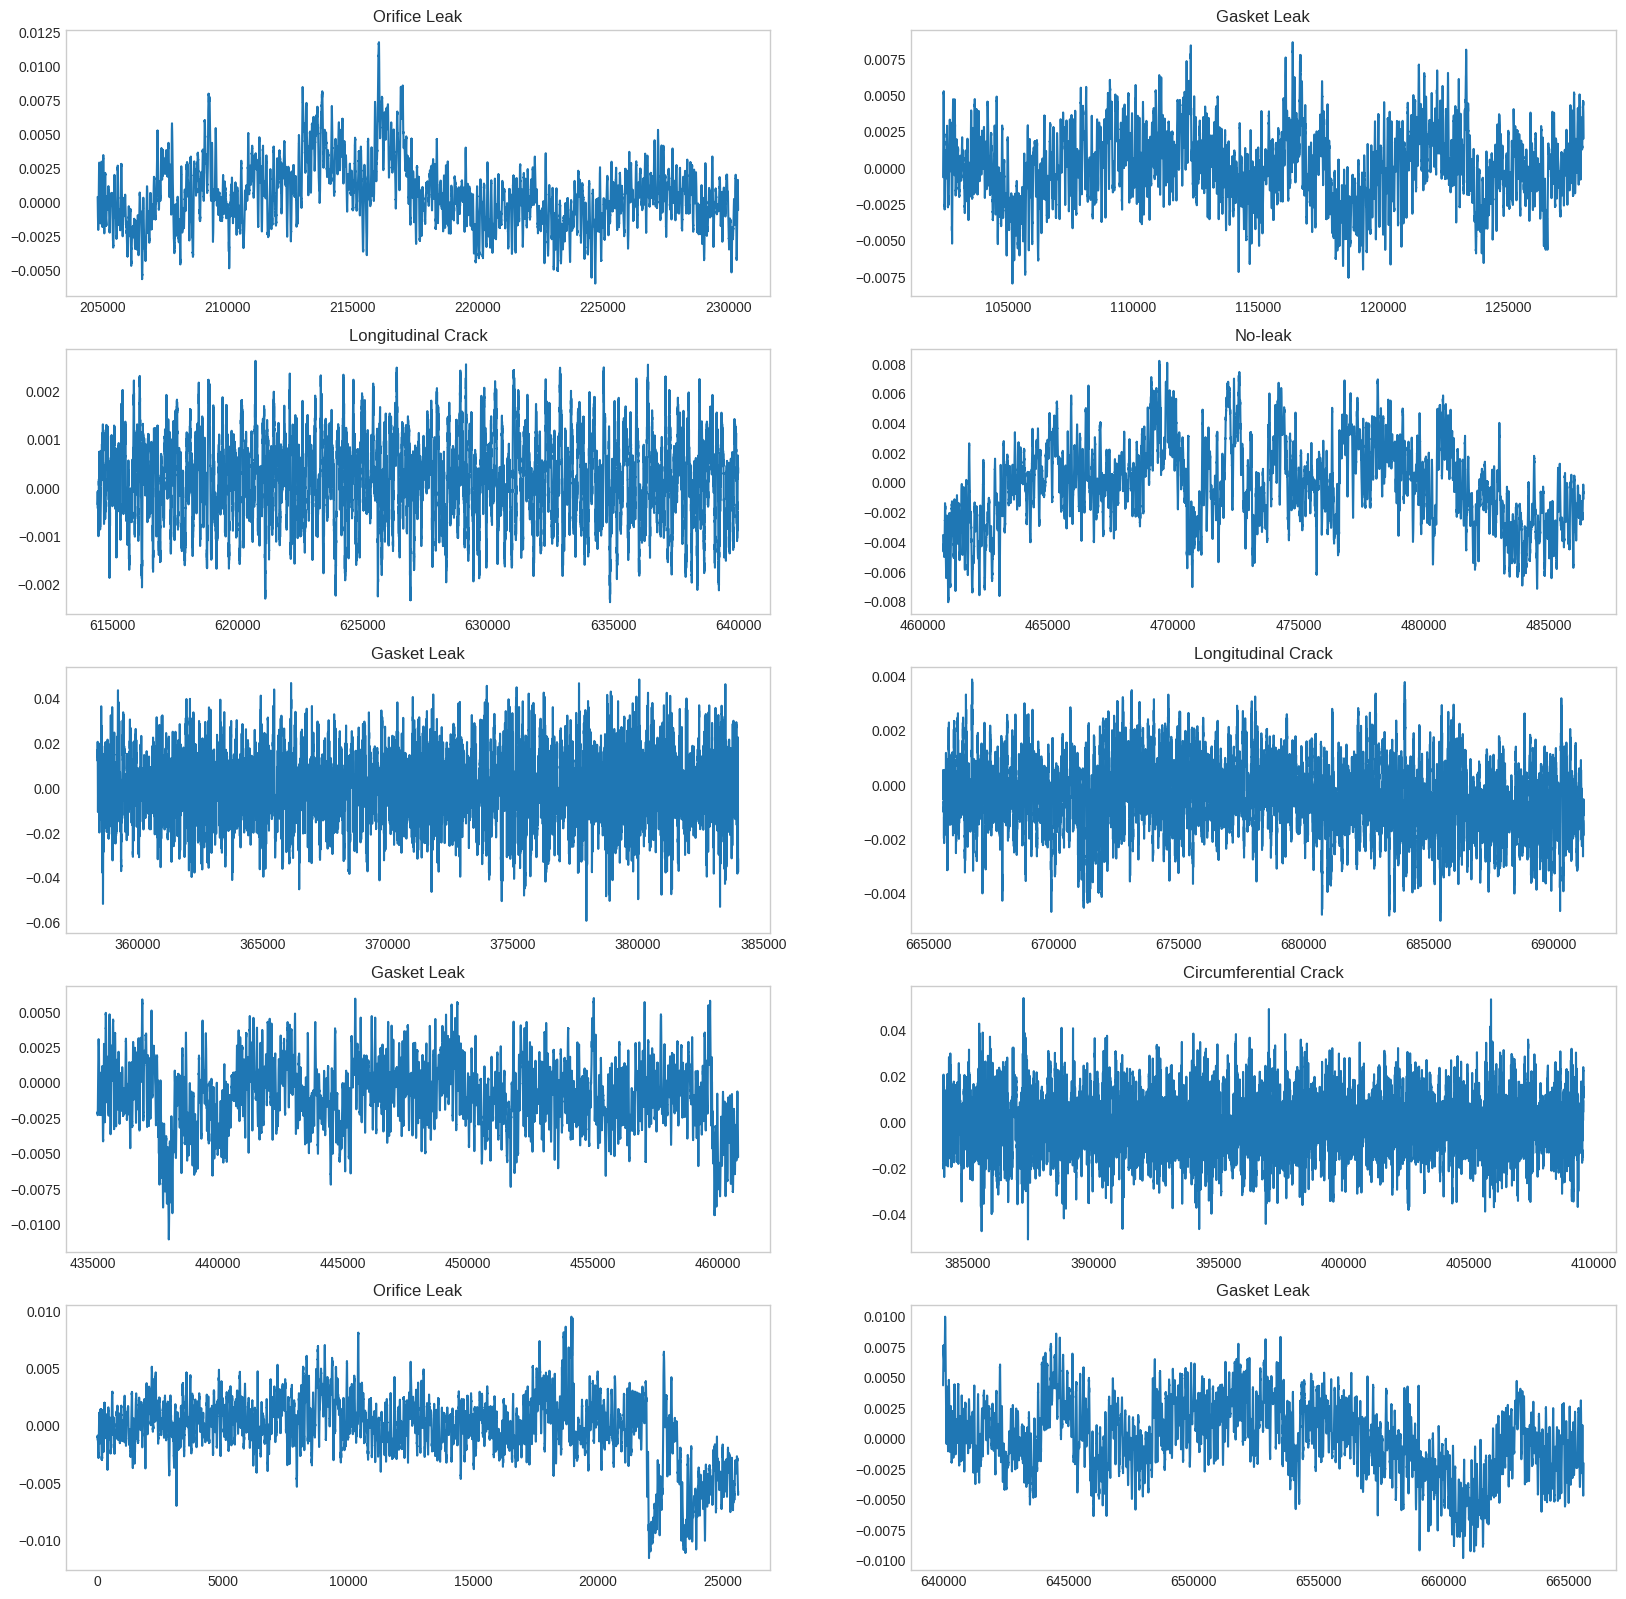

In [3]:
# Definir la ruta de los datos en Google Drive
data_dir = '/content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched'
original_sr = 25600  # Frecuencia de muestreo original en Hz
signal_sr = 25600  # Frecuencia de muestreo deseada en Hz
downsample_factor = original_sr // signal_sr

# Modo de clasificación: 'five_classes' o 'binary'
classification_mode = 'five_classes'  # Cambiar según necesidad

# Diccionario de etiquetas según el modo de clasificación
if classification_mode == 'five_classes':
    label_codes_dict = {
        'Circumferential Crack': 0,
        'Gasket Leak': 1,
        'Longitudinal Crack': 2,
        'No-leak': 3,
        'Orifice Leak': 4
    }
else:  # binary
    label_codes_dict = {'Leak': 0, 'No-leak': 1}

# Función para eliminar archivos .DS_Store si existen
def remove_DS_store_file(path):
    for ds_name in ['.DS_Store', '.DS_store']:
        ds_store_file_location = os.path.join(path, ds_name)
        if os.path.isfile(ds_store_file_location):
            os.remove(ds_store_file_location)

def load_accelerometer_data(data_dir, sample_rate, downsample_factor, label_codes, mode='five_classes', fraction_to_include=1):
    remove_DS_store_file(data_dir)
    signals = []
    labels = []

    # Para submuestreo en modo binario
    if mode == 'binary':
        # Diccionario para rastrear señales por tipo de fuga
        leak_type_signals = {
            'Circumferential Crack': [],
            'Gasket Leak': [],
            'Longitudinal Crack': [],
            'Orifice Leak': []
        }
        no_leak_signals = []
        sample_labels = []  # Para almacenar etiquetas originales (para estratificación)

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir):
            print(f"Omitiendo {label_dir} porque no es un directorio")
            continue

        remove_DS_store_file(label_dir)

        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            if not os.path.isfile(file_path):
                continue

            accelerometer_signal_df = pd.read_csv(file_path, index_col=False)
            accelerometer_signal_df = accelerometer_signal_df.iloc[::downsample_factor, :].reset_index(drop=True)
            accelerometer_signal = accelerometer_signal_df['Value'][0:(sample_rate * 30)]

            sample_indexes = np.linspace(0, len(accelerometer_signal) - sample_rate, len(accelerometer_signal) // sample_rate)
            signal_frames_number = fraction_to_include * len(sample_indexes)
            signal_frames_counter = 0

            for signal_frame in sample_indexes:
                accelerometer_signal_frame = accelerometer_signal[int(signal_frame):int(signal_frame + sample_rate)]
                signal_frames_counter += 1

                if signal_frames_counter > signal_frames_number:
                    break

                if len(accelerometer_signal_frame) != sample_rate:
                    continue

                if mode == 'five_classes':
                    signals.append(accelerometer_signal_frame)
                    labels.append(label_codes[label])
                else:  # binary
                    # En vez de añadir directamente, almacenamos por tipo de fuga
                    if label == 'No-leak':
                        no_leak_signals.append(accelerometer_signal_frame)
                        sample_labels.append('No-leak')
                    else:
                        # Almacenar en el diccionario correspondiente
                        leak_type_signals[label].append(accelerometer_signal_frame)
                        sample_labels.append(label)

    # Para modo binario, realizar submuestreo equilibrado
    if mode == 'binary':
        # Número total de muestras No-leak
        total_no_leak = len(no_leak_signals)

        # Calcular cuántas muestras tomar de cada tipo de fuga para balancear con No-leak
        samples_per_leak_type = total_no_leak // 4  # Dividir entre los 4 tipos de fuga

        # Si hay muy pocas muestras de algún tipo, ajustar todas para mantener la proporcionalidad
        min_available = min([len(leak_signals) for leak_signals in leak_type_signals.values()])
        if min_available < samples_per_leak_type:
            samples_per_leak_type = min_available

        # Limitar cada tipo de fuga a la cantidad calculada para balanceo
        balanced_leak_signals = []
        balanced_labels = []
        balanced_stratify = []

        # Añadir todas las muestras No-leak
        for signal in no_leak_signals:
            balanced_leak_signals.append(signal)
            balanced_labels.append(1)  # No-leak
            balanced_stratify.append('No-leak')

        # Añadir cantidades equilibradas de cada tipo de fuga
        for leak_type, leak_signals in leak_type_signals.items():
            # Tomar exactamente samples_per_leak_type muestras de cada tipo de fuga
            for signal in leak_signals[:samples_per_leak_type]:
                balanced_leak_signals.append(signal)
                balanced_labels.append(0)  # Leak
                balanced_stratify.append(leak_type)  # Guardar tipo original para estratificación

        print(f"Balanceo de clases aplicado:")
        print(f"- Muestras No-leak: {total_no_leak}")
        print(f"- Muestras Leak (total): {samples_per_leak_type * 4}")
        print(f"- Muestras por tipo de fuga: {samples_per_leak_type}")

        return balanced_leak_signals, balanced_labels, balanced_stratify

    return signals, labels, None  # None para modo five_classes

# Cargar los datos con submuestreo equilibrado
signals_lst, labels_lst, stratify_labels = load_accelerometer_data(
    data_dir,
    signal_sr,
    downsample_factor,
    label_codes_dict,
    mode=classification_mode,
    fraction_to_include=1
)

# Dividir los datos en conjuntos de entrenamiento y prueba con estratificación
signals_dict = {'training': [], 'testing': []}
labels_dict = {'training': [], 'testing': []}

if stratify_labels:
    signals_dict['training'], signals_dict['testing'], labels_dict['training'], labels_dict['testing'], stratify_train, stratify_test = train_test_split(
        signals_lst,
        labels_lst,
        stratify_labels,
        test_size=0.2,
        random_state=53,
        stratify=stratify_labels
    )
else:
    # Para modo five_classes, usar las etiquetas para estratificar
    signals_dict['training'], signals_dict['testing'], labels_dict['training'], labels_dict['testing'] = train_test_split(
        signals_lst,
        labels_lst,
        test_size=0.2,
        random_state=53,
        stratify=labels_lst  # Estratificar por las etiquetas directamente
    )

# Imprimir información sobre el dataset
print(f'Data Directory: {data_dir}')
print(f'Sample Rate: {signal_sr} Hz')
print(f'Classification Mode: {classification_mode}')
print(f'Number of signals (training, testing): ({len(signals_dict["training"])}, {len(signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(signals_dict["training"][0])}')


# Visualizar algunas señales
plt.figure(figsize=(20, 20))
rows, cols = 5, 2
n = rows * cols
random_index = []

for i in range(n):
    plt.subplot(rows, cols, i + 1)
    random_index.append(np.random.randint(0, len(signals_dict['training'])))
    plt.plot(signals_dict['training'][random_index[i]])

    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()
plt.show()


# Mostrando segmentos de señales de un segundo por cada clase

Figura guardada en: senales_por_clase_tesis.png


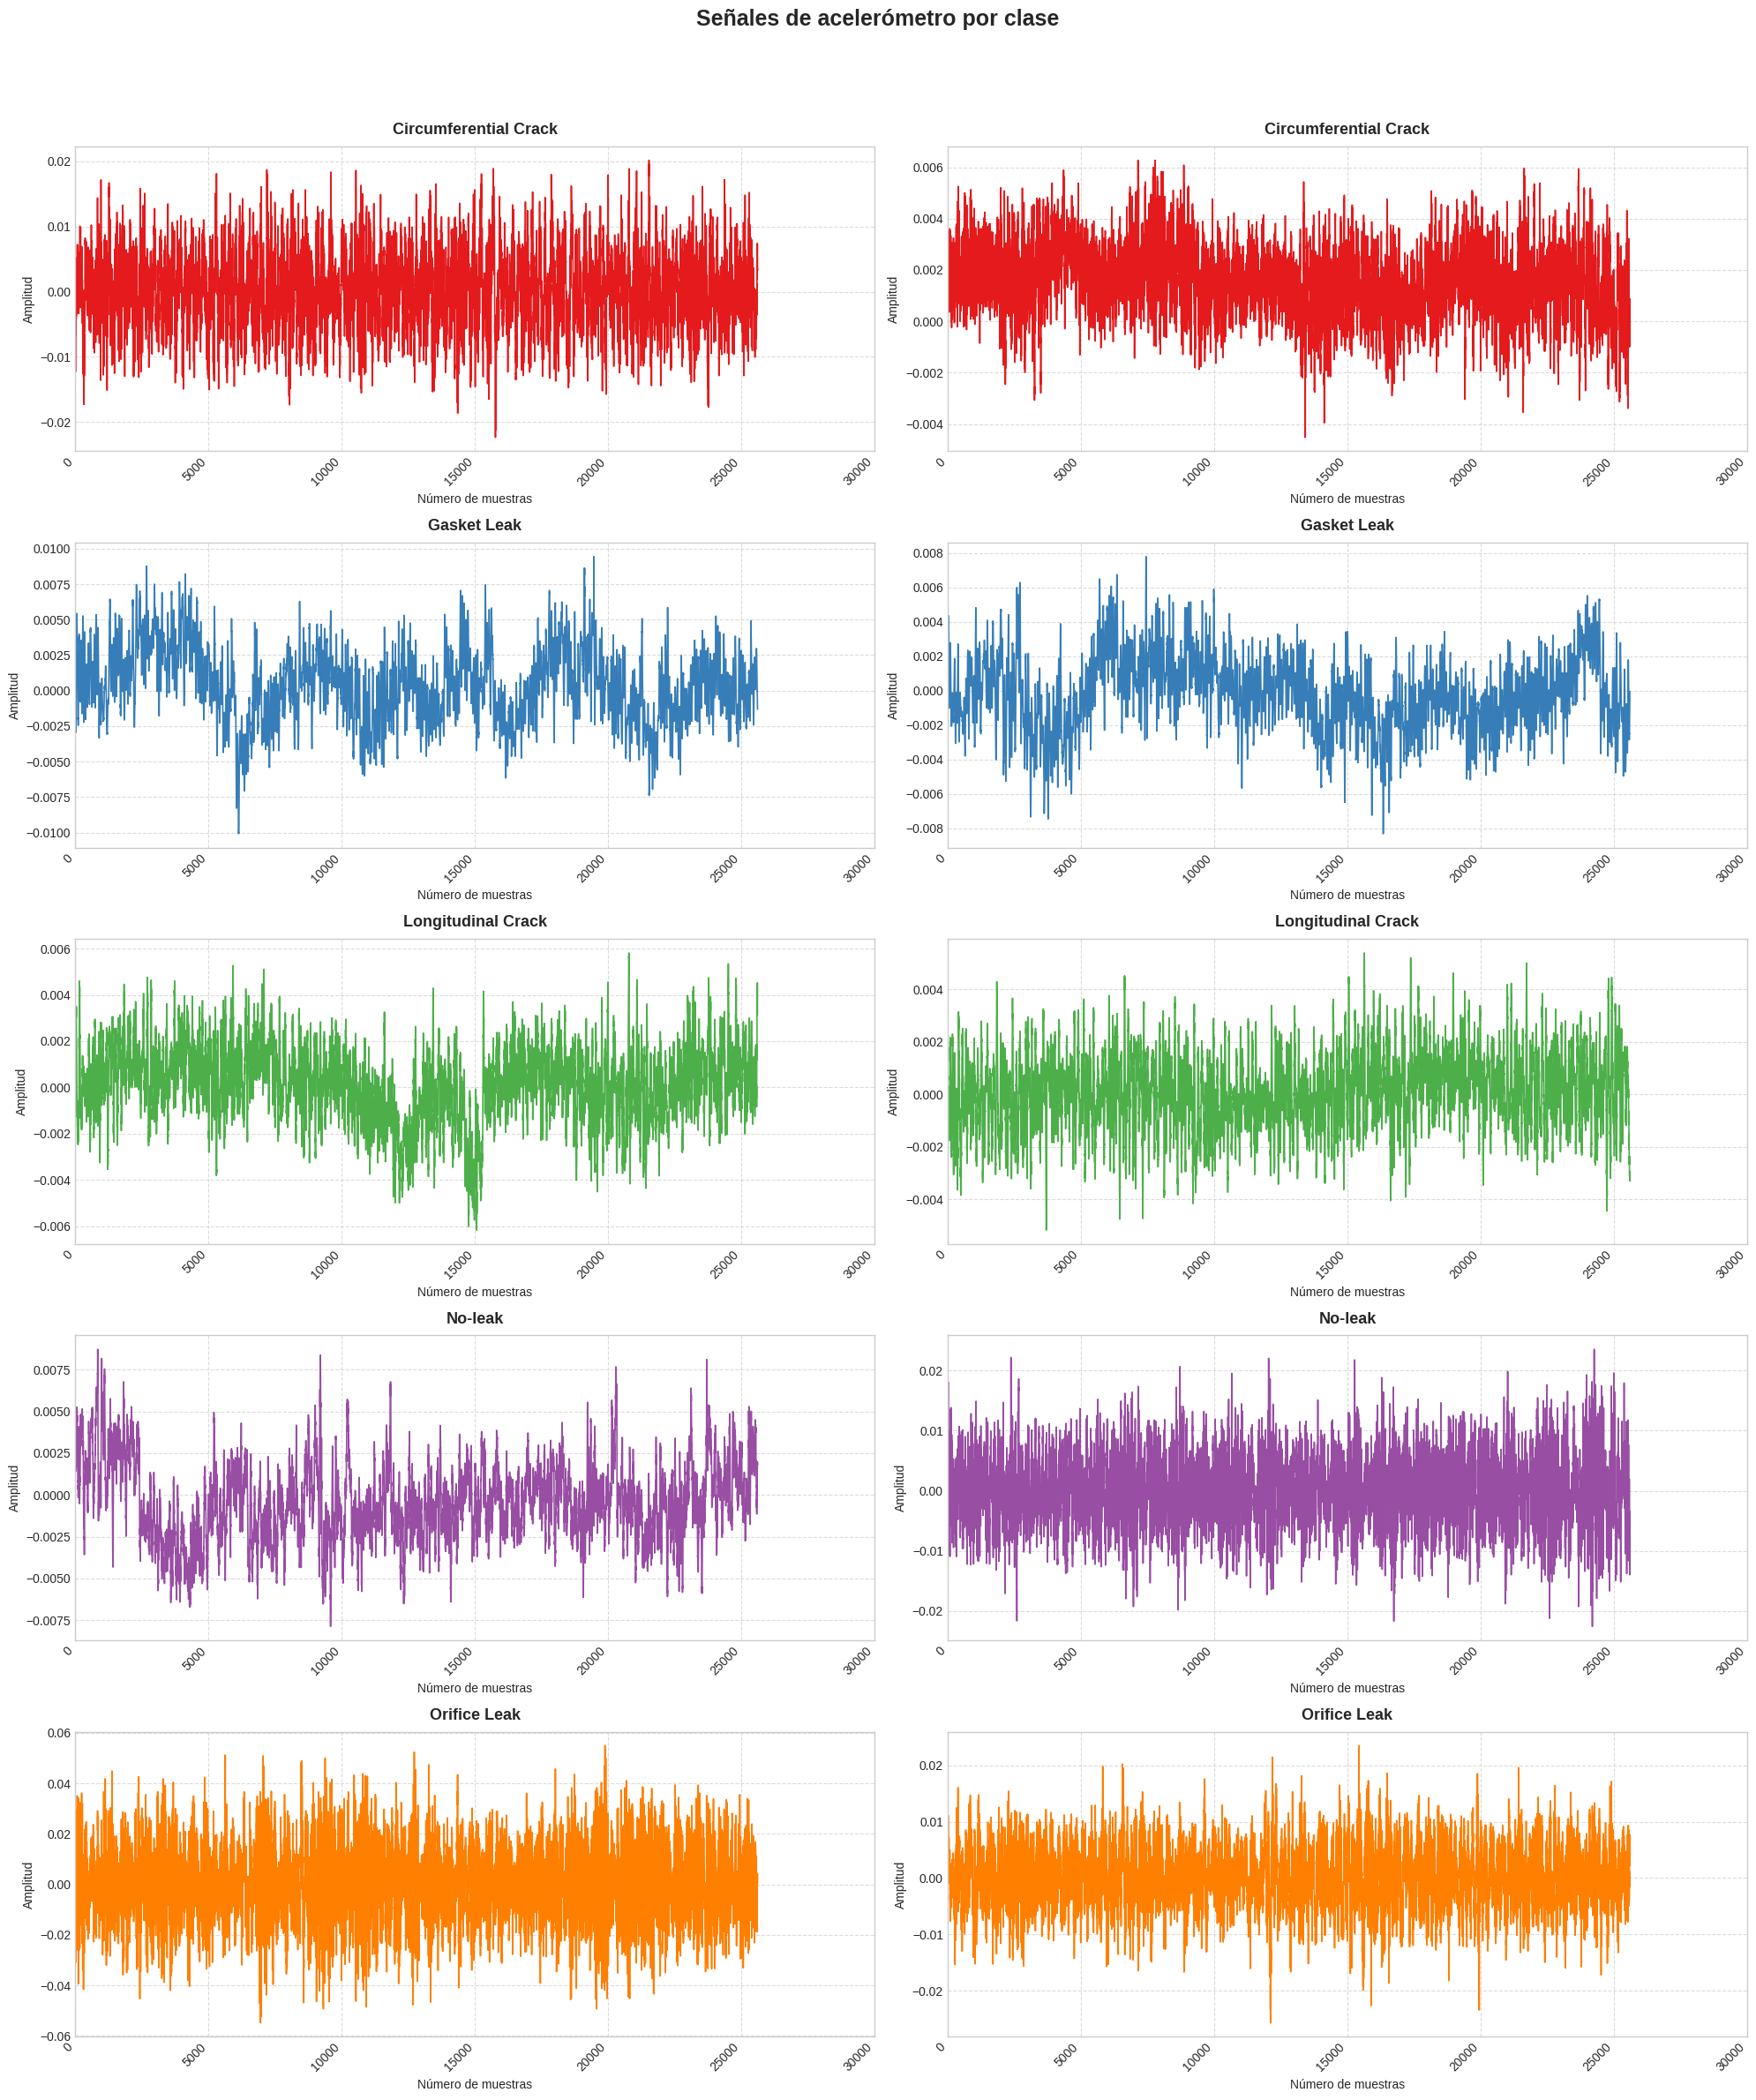

In [ ]:
def view_signals(signals_dict, labels_dict, classification_mode='five_classes',
                               label_codes_dict=None, figsize=(20, 25), save_path=None, dpi=300):
    """
    Visualiza 2 señales de cada clase con calidad para publicación académica.

    Args:
        signals_dict: Diccionario con señales {'training': [...], 'testing': [...]}
        labels_dict: Diccionario con etiquetas {'training': [...], 'testing': [...]}
        classification_mode: Modo de clasificación ('five_classes' o 'binary')
        label_codes_dict: Diccionario de códigos de etiquetas
        figsize: Tamaño de la figura (ancho, alto) en pulgadas
        save_path: Ruta para guardar la figura (opcional)
        dpi: Resolución para guardar la figura
    """
    # Configurar estilo de visualización científica
    plt.style.use('seaborn-v0_8-whitegrid')

    # Definir paleta de colores para cada clase
    paleta_colores = {
        'Circumferential Crack': '#E41A1C',  # Rojo
        'Gasket Leak': '#377EB8',            # Azul
        'Longitudinal Crack': '#4DAF4A',      # Verde
        'No-leak': '#984EA3',                # Morado
        'Orifice Leak': '#FF7F00',           # Naranja
        'Leak': '#E41A1C'                    # Rojo (para modo binario)
    }

    # Identificar clases únicas y preparar diccionario para almacenar índices por clase
    if classification_mode == 'five_classes':
        clases_unicas = list(label_codes_dict.keys())
        num_clases = len(clases_unicas)
        codigo_a_nombre = {valor: clave for clave, valor in label_codes_dict.items()}
    else:  # binary
        clases_unicas = ['Leak', 'No-leak']
        num_clases = 2
        codigo_a_nombre = {0: 'Leak', 1: 'No-leak'}

    # Crear figura para visualización
    fig = plt.figure(figsize=figsize, constrained_layout=False)

    # Configurar el diseño de la figura
    rows = num_clases
    cols = 2  # Dos señales por clase

    # Recopilar índices por clase
    indices_por_clase = {}
    for i, etiqueta in enumerate(labels_dict['training']):
        nombre_clase = codigo_a_nombre[etiqueta]
        if nombre_clase not in indices_por_clase:
            indices_por_clase[nombre_clase] = []
        indices_por_clase[nombre_clase].append(i)

    # Ajuste de tamaño de fuente basado en el número de clases
    tamano_titulo = 15 if num_clases <= 3 else 13
    tamano_ejes = 12 if num_clases <= 3 else 10

    # Vector de tiempo/muestras para el eje x (como solicitaste)
    num_muestras = len(signals_dict['training'][0])
    eje_x = np.arange(num_muestras)  # De 0 a 25600

    # Dibujar señales
    for i, clase in enumerate(clases_unicas):
        # Obtener índices para esta clase
        indices_clase = indices_por_clase.get(clase, [])

        # Verificar que haya suficientes muestras
        if len(indices_clase) >= 2:
            # Seleccionar 2 índices aleatorios para esta clase
            seleccionados = np.random.choice(indices_clase, 2, replace=False)
        else:
            # Si no hay 2 índices disponibles, usar los que haya (posiblemente con repetición)
            seleccionados = np.random.choice(indices_clase, 2, replace=True) if indices_clase else [0, 0]

        # Dibujar 2 señales para esta clase
        for j, idx in enumerate(seleccionados):
            # Crear subplot
            ax = fig.add_subplot(rows, cols, i * cols + j + 1)

            # Extraer la señal
            signal = signals_dict['training'][idx]

            # Dibujar la señal con estilo mejorado
            ax.plot(eje_x, signal, linewidth=1.2, color=paleta_colores.get(clase, '#333333'))

            # Rellenar área bajo la curva para mejor visualización
            #ax.fill_between(eje_x, signal, alpha=0.15, color=paleta_colores.get(clase, '#333333'))

            # Configurar título y etiquetas
            ax.set_title(f"{clase}", fontsize=tamano_titulo, fontweight='bold', pad=10)
            ax.set_xlabel('Número de muestras', fontsize=tamano_ejes)
            ax.set_ylabel('Amplitud', fontsize=tamano_ejes)

            # Ajustar límites y formato de ejes
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.set_xlim(0, num_muestras)

            # Añadir marcadores para divisiones principales en miles
            paso_mayor = 5000
            ax.set_xticks(np.arange(0, num_muestras + paso_mayor, paso_mayor))

            # Mejorar márgenes para evitar solapamiento
            for label in ax.get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')

    # Título general y ajustes finales
    fig.suptitle('Señales de acelerómetro por clase', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Guardar si se proporciona una ruta
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Figura guardada en: {save_path}")

    # Mostrar la figura
    plt.show()

    # Devolver índices utilizados para referencia
    return {clase: indices_por_clase.get(clase, [])[:2] for clase in clases_unicas}


# Visualizar exactamente 2 señales por cada clase
indices_utilizados = view_signals(
    signals_dict=signals_dict,
    labels_dict=labels_dict,
    classification_mode=classification_mode,
    label_codes_dict=label_codes_dict,
    figsize=(20, 25),
    save_path="senales_por_clase_tesis.png",
    dpi=300
)

# Comprobando el balanceo de clases

Verificando balance de clases en datos cargados...

--- Balance de clases - Dataset completo ---
Total de muestras: 1200
Leak: 240 muestras (20.00%)
No-leak: 240 muestras (20.00%)
Clase 2: 240 muestras (20.00%)
Clase 3: 240 muestras (20.00%)
Clase 4: 240 muestras (20.00%)
Ratio de desequilibrio: 1.00


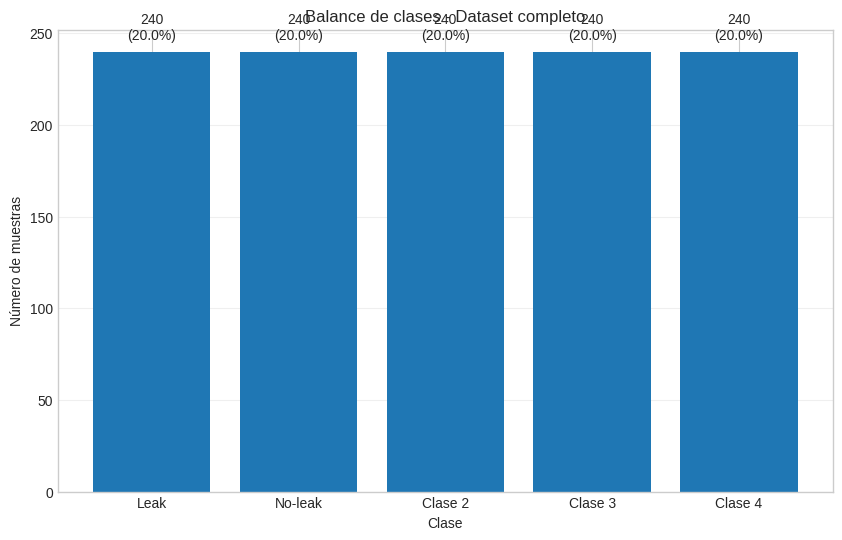

Verificando balance de clases en conjuntos de entrenamiento y prueba...

--- Balance de clases - Conjunto de entrenamiento ---
Total de muestras: 960
Leak: 192 muestras (20.00%)
No-leak: 192 muestras (20.00%)
Clase 2: 192 muestras (20.00%)
Clase 3: 192 muestras (20.00%)
Clase 4: 192 muestras (20.00%)
Ratio de desequilibrio: 1.00


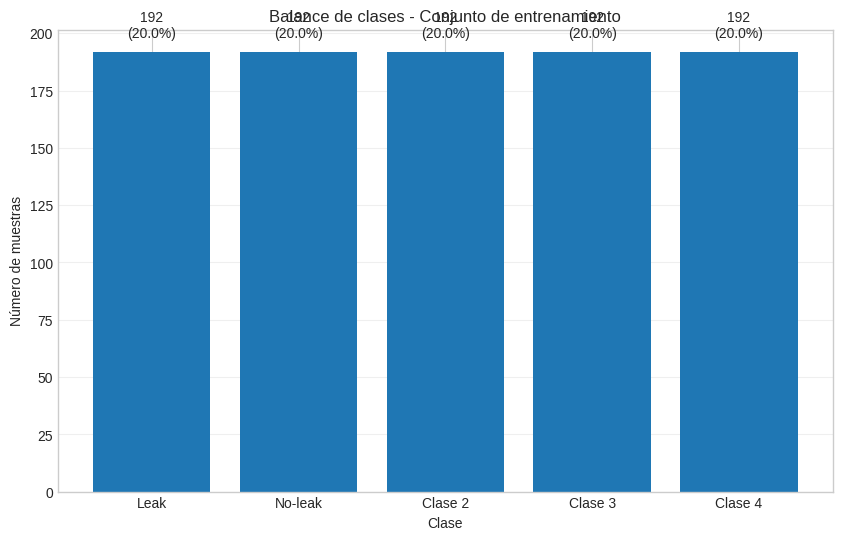


--- Balance de clases - Conjunto de prueba ---
Total de muestras: 240
Leak: 48 muestras (20.00%)
No-leak: 48 muestras (20.00%)
Clase 2: 48 muestras (20.00%)
Clase 3: 48 muestras (20.00%)
Clase 4: 48 muestras (20.00%)
Ratio de desequilibrio: 1.00


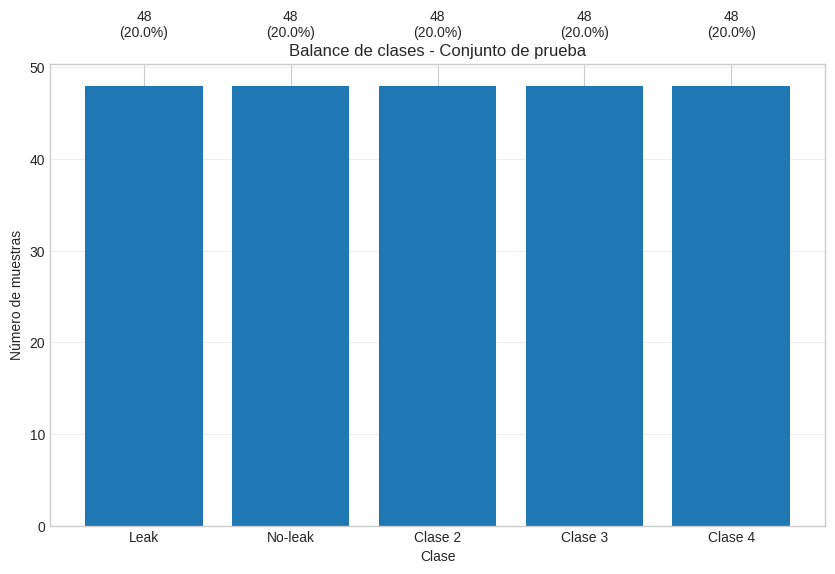

In [ ]:
# Función para analizar el balance de clases
def check_class_balance(labels, label_codes_dict, title="Distribución de clases"):
    """
    Verifica el balance de clases en un conjunto de etiquetas.

    Args:
        labels: Lista o array de etiquetas.
        label_codes_dict: Diccionario que mapea nombres de clases a códigos numéricos.
        title: Título para el gráfico.
    """
    # Invertir el diccionario para mapear códigos a nombres
    if 'five_classes' in globals() and globals()['classification_mode'] == 'five_classes':
        code_to_label = {code: name for name, code in label_codes_dict.items()}
    else:
        code_to_label = {0: 'Leak', 1: 'No-leak'}

    # Contar las ocurrencias de cada clase
    unique_labels, counts = np.unique(labels, return_counts=True)
    # Asegurarse de que todas las etiquetas únicas estén en code_to_label
    for label in unique_labels:
        if label not in code_to_label:
            # Si la etiqueta no está en el diccionario, añadirla con un nombre genérico
            code_to_label[label] = f"Clase {label}"

    class_distribution = {code_to_label[label]: count for label, count in zip(unique_labels, counts)}


    # Calcular porcentajes
    total_samples = len(labels)
    percentages = {cls: (count / total_samples) * 100 for cls, count in class_distribution.items()}

    # Mostrar resultados
    print(f"\n--- {title} ---")
    print(f"Total de muestras: {total_samples}")
    for cls, count in class_distribution.items():
        print(f"{cls}: {count} muestras ({percentages[cls]:.2f}%)")

    # Calcular ratio de desequilibrio (clase mayoritaria vs minoritaria)
    if len(class_distribution) > 1:
        max_class = max(class_distribution.values())
        min_class = min(class_distribution.values())
        imbalance_ratio = max_class / min_class
        print(f"Ratio de desequilibrio: {imbalance_ratio:.2f}")

    # Visualizar distribución
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_distribution.keys(), class_distribution.values())

    # Agregar etiquetas con el número de muestras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                 f'{height}\n({height/total_samples*100:.1f}%)',
                 ha='center', va='bottom')

    plt.title(title)
    plt.xlabel('Clase')
    plt.ylabel('Número de muestras')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Comprobar balance en el conjunto completo
print("Verificando balance de clases en datos cargados...")
check_class_balance(labels_lst, label_codes_dict, "Balance de clases - Dataset completo")

# Comprobar balance en conjuntos de entrenamiento y prueba
print("Verificando balance de clases en conjuntos de entrenamiento y prueba...")
check_class_balance(labels_dict['training'], label_codes_dict, "Balance de clases - Conjunto de entrenamiento")
check_class_balance(labels_dict['testing'], label_codes_dict, "Balance de clases - Conjunto de prueba")

# Si estamos usando modo binario, verificar la representación de tipos de fuga
if classification_mode == 'binary' and 'stratify_labels' in locals() and stratify_labels:
    # Filtrar solo las muestras con etiqueta 0 (Leak)
    # Filtrar solo las muestras con etiqueta 0 (Leak)
    leak_indices = [i for i, label in enumerate(labels_dict['training']) if label == 0]
    leak_types = [stratify_train[i] for i in leak_indices]

    # Contar por tipo de fuga
    unique_leaks, leak_counts = np.unique(leak_types, return_counts=True)
    leak_distribution = {leak_type: count for leak_type, count in zip(unique_leaks, leak_counts)}

    # Visualizar distribución de tipos de fuga
    plt.figure(figsize=(10, 6))
    bars = plt.bar(leak_distribution.keys(), leak_distribution.values())

    # Agregar etiquetas con el número de muestras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                 f'{height}', ha='center', va='bottom')

    plt.title("Distribución de tipos de fuga en clase 'Leak'")
    plt.xlabel('Tipo de fuga')
    plt.ylabel('Número de muestras')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Normalización y Denoising con Wavelet
Aplicación de técnicas de denoising basadas en wavelet para eliminar el ruido en las señales completas. Normalización posterior para preparar los datos para el cálculo de CWT.

========= INICIANDO PRUEBA DE DENOISING WAVELET =========
Versión de PyWavelets: 1.8.0
COMENZANDO DENOISING DE SEÑALES...

========= INICIANDO PROCESO DE DENOISING =========
Seleccionando muestra aleatoria para encontrar wavelet óptima...
Muestra seleccionada: índice=701, longitud=25600

Procesando muestra para encontrar parámetros óptimos...
Inicializando AdaptiveWaveletDenoising: use_optimal=True, n_best=3

=== INICIANDO DENOISING ADAPTATIVO ===
Inicializando OptimalWaveletSelector
Wavelets a probar: ['db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8']
Espacio de búsqueda creado con 33 wavelets

--- BUSCANDO WAVELET ÓPTIMA ---
Longitud de la señal: 25600
Nivel máximo considerado: 14
Evaluando 33 wavelets...

Probando wavelet: db2
  Obteniendo 

  0%|          | 0/960 [00:00<?, ?it/s]

Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coi

  0%|          | 0/240 [00:00<?, ?it/s]

Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coif5, nivel=7
Inicializando WaveletDenoising: wavelet=coif5, level=7
Aplicando wavedec con coi

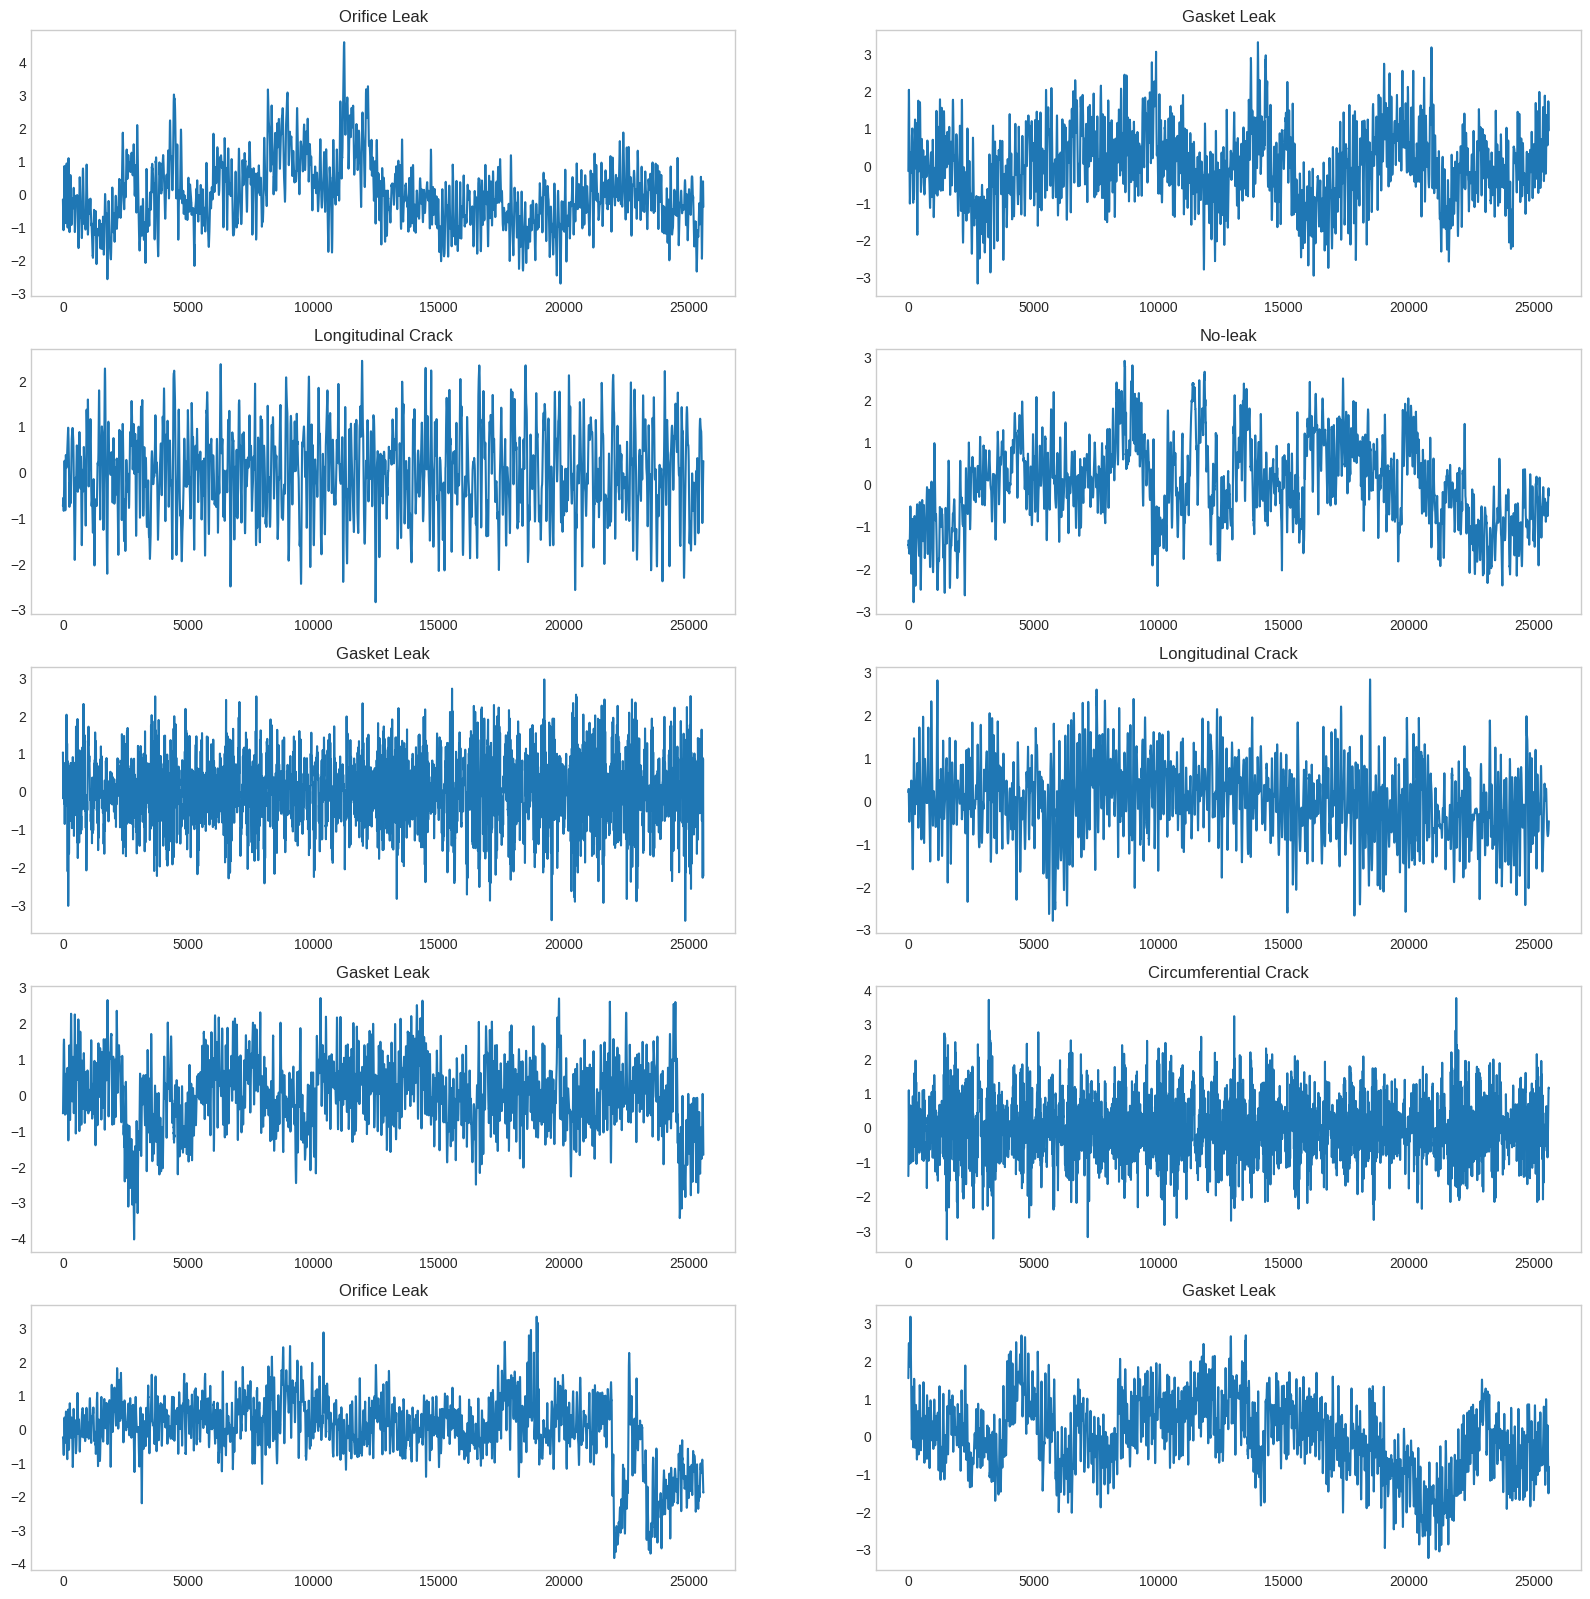

Normalizando señales procesadas con wavelet denoising...


Normalizando training signals:   0%|          | 0/960 [00:00<?, ?it/s]

Normalizando testing signals:   0%|          | 0/240 [00:00<?, ?it/s]

Number of signals (training, testing): (960, 240)
Number of samples per signal: 25600
Rango de valores en training: [0.0000, 1.0000]
Rango de valores en testing: [0.0000, 1.0000]


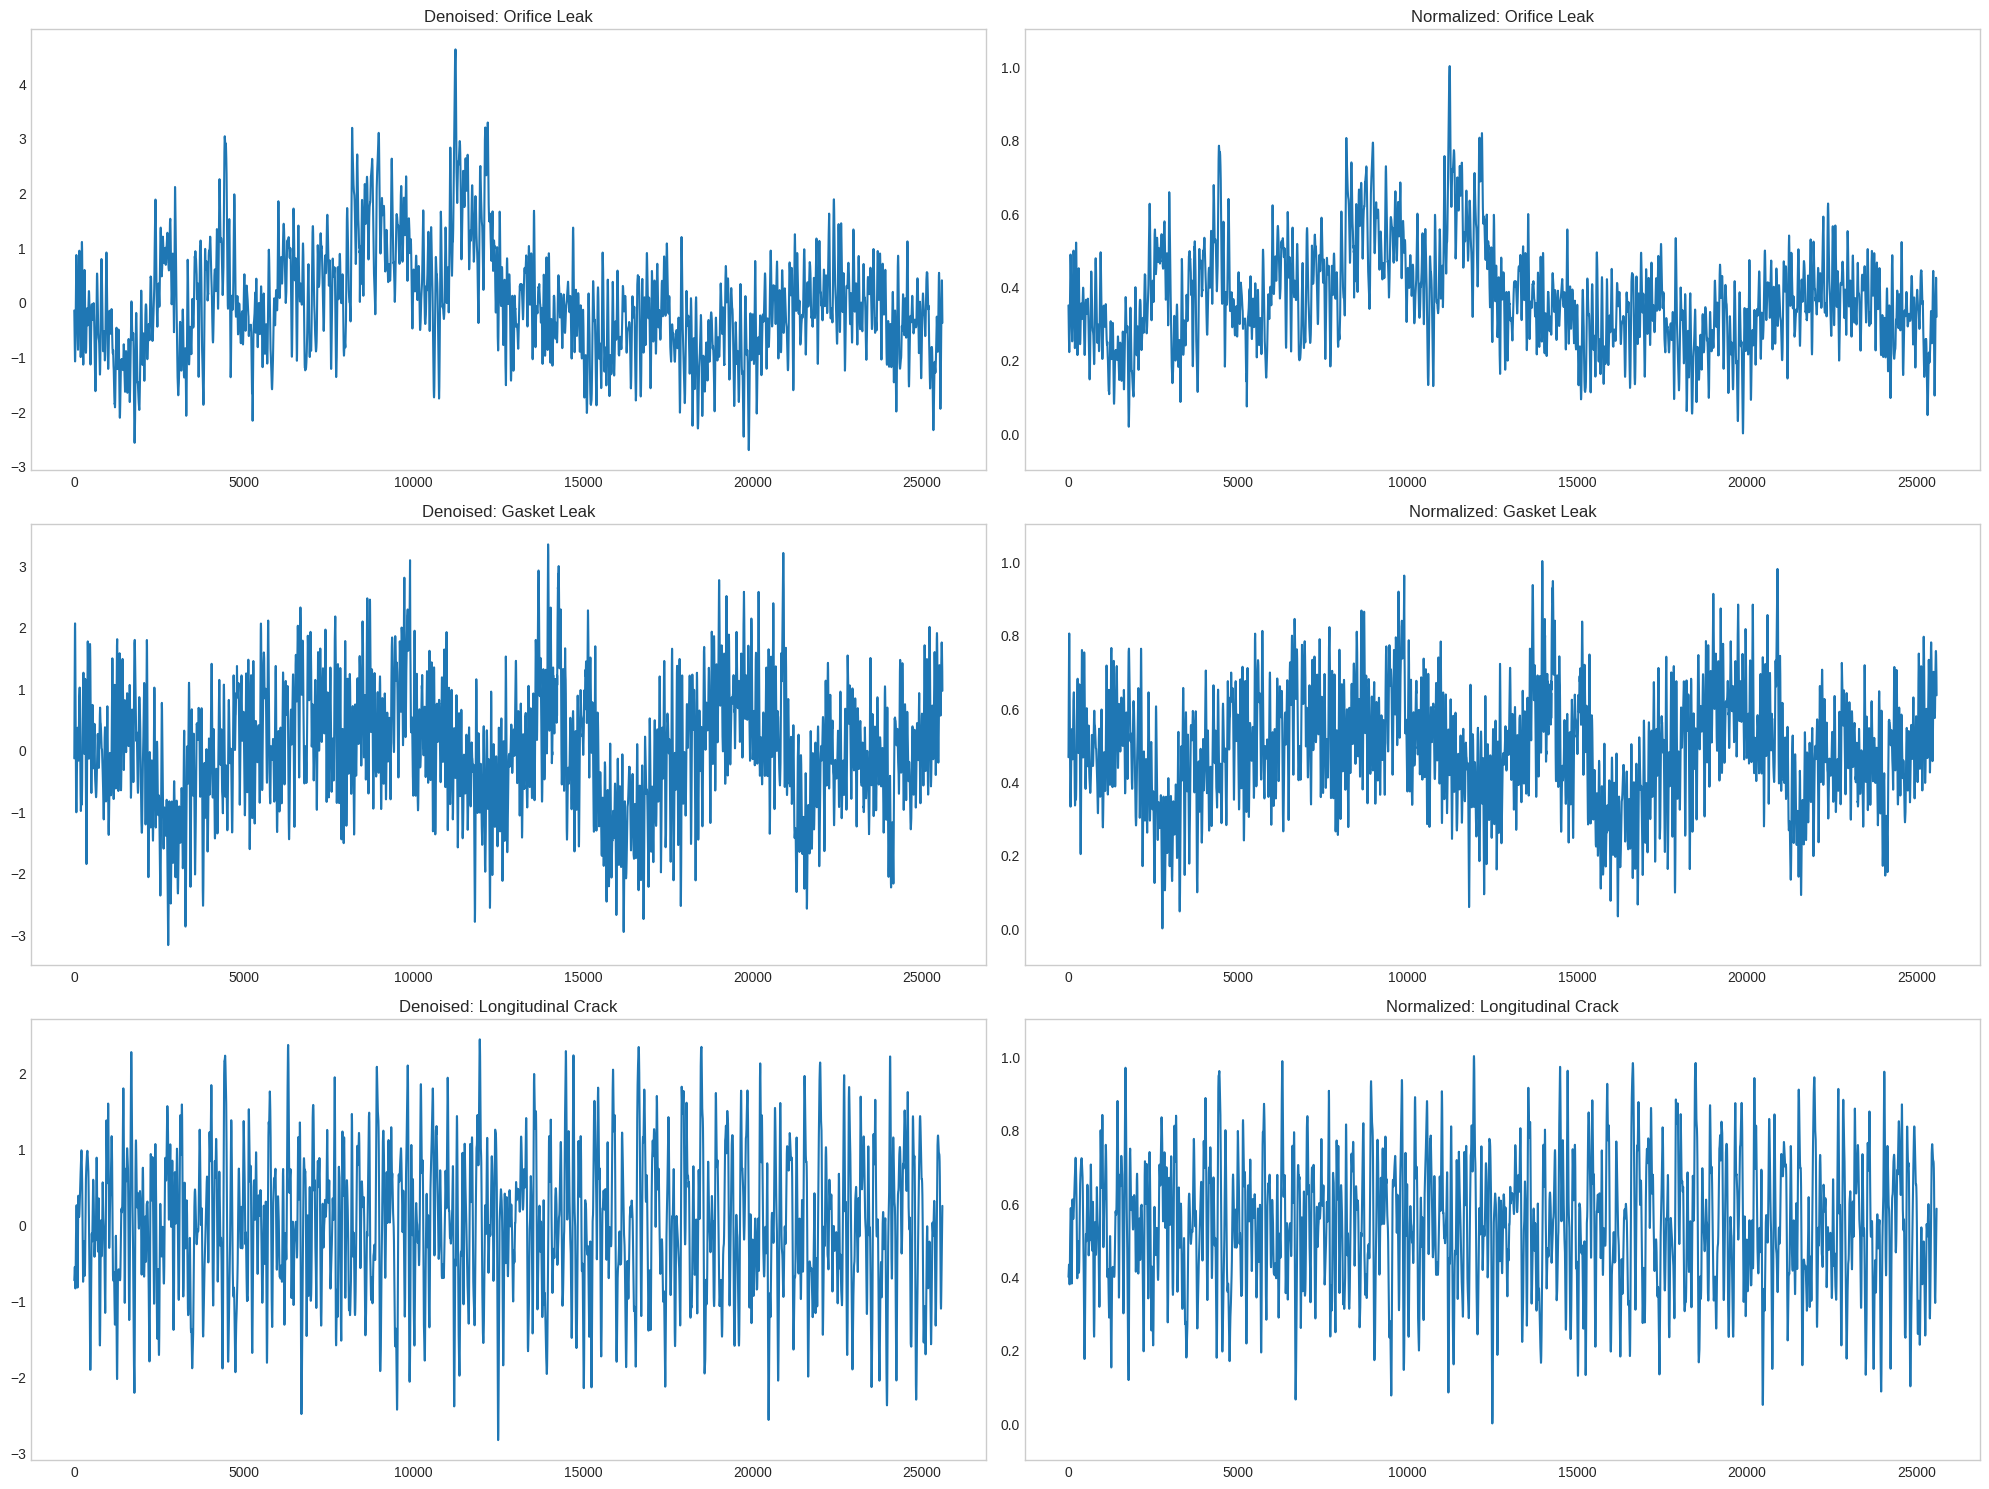

In [11]:
# Mega celda para identificar el error en el denoising wavelet
import numpy as np
import pywt
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy import signal
import time

print("========= INICIANDO PRUEBA DE DENOISING WAVELET =========")
print(f"Versión de PyWavelets: {pywt.__version__}")

class WaveletDenoising:
    """Clase básica para denoising con wavelets."""

    def __init__(self, normalize=True, wavelet='db4', level=3, thr_mode='soft',
                 method="universal"):
        print(f"Inicializando WaveletDenoising: wavelet={wavelet}, level={level}")
        self.normalize = normalize
        self.wavelet = wavelet
        self.level = level
        self.thr_mode = thr_mode
        self.method = method

    def fit(self, data):
        """Aplica el denoising a los datos de entrada."""
        # Convertir a array numpy
        data = np.asarray(data)

        # Normalizar si es necesario
        if self.normalize:
            data = (data - np.mean(data)) / (np.std(data) if np.std(data) != 0 else 1.0)

        # Descomponer con wavelet
        print(f"Aplicando wavedec con {self.wavelet}, nivel={self.level}")
        coeffs = pywt.wavedec(data, self.wavelet, level=self.level)

        # Umbral
        if self.method == "universal":
            sigma = self._estimate_sigma(coeffs[-1])
            threshold = sigma * np.sqrt(2 * np.log(len(data)))
        else:
            threshold = self._estimate_level_dependent_threshold(coeffs)

        # Aplicar umbral
        new_coeffs = []
        new_coeffs.append(coeffs[0])  # Aproximación
        for i in range(1, len(coeffs)):
            if self.thr_mode == 'soft':
                new_coeffs.append(pywt.threshold(coeffs[i], threshold, mode='soft'))
            else:
                new_coeffs.append(pywt.threshold(coeffs[i], threshold, mode='hard'))

        # Reconstruir
        return pywt.waverec(new_coeffs, self.wavelet)

    def _estimate_sigma(self, detail_coeffs):
        """Estima la desviación estándar del ruido."""
        return np.median(np.abs(detail_coeffs)) / 0.6745

    def _estimate_level_dependent_threshold(self, coeffs):
        """Estima umbrales dependientes del nivel."""
        return np.std(coeffs[-1]) * 3.0


class OptimalWaveletSelector:
    """Implementación para selección automática de wavelets óptimas."""

    def __init__(self, max_level=None, sparsity_change_threshold=0.05):
        print("Inicializando OptimalWaveletSelector")
        self.max_level = max_level
        self.sparsity_change_threshold = sparsity_change_threshold
        self.optimal_wavelet = None
        self.optimal_level = None
        self.wavelet_space = self._create_wavelet_space()
        print(f"Espacio de búsqueda creado con {len(self.wavelet_space)} wavelets")

    def _create_wavelet_space(self):
        """Crea el espacio de búsqueda de wavelets."""
        # Lista simplificada para pruebas - usar solo wavelets que sabemos que funcionan
        wavelet_families = [
            'db2', 'db3', 'db4','db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11',
            'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7',
            'bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6',
            'coif1', 'coif2', 'coif3', 'coif4', 'coif5',
            'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8'
        ]
        print(f"Wavelets a probar: {wavelet_families}")
        return wavelet_families

    def calculate_sparsity(self, coeffs):
        """Calcula la esparsidad para cada nivel de coeficientes."""
        sparsity = []
        for level_idx, coeff in enumerate(coeffs):
            try:
                print(f"    Procesando nivel {level_idx+1}, tipo={type(coeff)}, forma={np.shape(coeff)}")

                if len(coeff) > 0:
                    max_abs = np.max(np.abs(coeff))
                    sum_abs = np.sum(np.abs(coeff))
                    if sum_abs > 0:
                        sparsity_value = max_abs / sum_abs
                    else:
                        sparsity_value = 0
                    sparsity.append(sparsity_value)
                    print(f"    Esparsidad nivel {level_idx+1}: {sparsity_value:.4f}")
                else:
                    sparsity.append(0)
                    print(f"    Nivel {level_idx+1}: coeficiente vacío, esparsidad = 0")
            except Exception as e:
                print(f"    ERROR en calculate_sparsity para nivel {level_idx+1}: {str(e)}")
                sparsity.append(0)

        return np.array(sparsity)

    def calculate_sparsity_change(self, sparsity):
        """Calcula el cambio de esparsidad entre niveles consecutivos."""
        sparsity_change = np.zeros_like(sparsity)
        for i in range(1, len(sparsity)):
            sparsity_change[i] = sparsity[i] - sparsity[i-1]
            print(f"    Cambio de esparsidad nivel {i}: {sparsity_change[i]:.4f}")
        return sparsity_change

    def find_optimal_level(self, sparsity_change):
        """Encuentra el nivel óptimo basado en el cambio de esparsidad."""
        optimal_level = 0
        for i in range(1, len(sparsity_change)):
            if sparsity_change[i] > self.sparsity_change_threshold:
                optimal_level = i - 1
                print(f"    Encontrado nivel óptimo: {optimal_level} (umbral superado: {sparsity_change[i]:.4f})")
                break

        # Si no se encontró nivel óptimo, usar el penúltimo nivel
        if optimal_level == 0 and len(sparsity_change) > 1:
            optimal_level = len(sparsity_change) - 2
            print(f"    No se encontró umbral significativo, usando nivel: {optimal_level}")

        return optimal_level

    def calculate_mean_sparsity_change(self, sparsity, optimal_level):
        """Calcula el cambio medio de esparsidad."""
        if optimal_level < 1:
            result = sparsity[0] if len(sparsity) > 0 else 0
            print(f"    Nivel óptimo < 1, μsc = {result:.4f}")
            return result
        else:
            result = (sparsity[optimal_level+1] - sparsity[0]) / optimal_level
            print(f"    μsc calculado: {result:.4f}")
            return result

    def find_optimal_wavelet(self, signal, n_best=1):
        """
        Encuentra la wavelet óptima para una señal.

        Args:
            signal: Señal de entrada.
            n_best: Número de mejores wavelets a devolver.

        Returns:
            Lista de tuplas (wavelet, nivel, μsc) ordenadas por μsc.
        """
        print("\n--- BUSCANDO WAVELET ÓPTIMA ---")
        signal = np.array(signal, dtype=np.float64)
        signal_length = len(signal)

        # Calcular el nivel máximo posible si no se proporciona
        if self.max_level is None:
            self.max_level = int(np.floor(np.log2(signal_length)))

        print(f"Longitud de la señal: {signal_length}")
        print(f"Nivel máximo considerado: {self.max_level}")

        # Resultados para cada wavelet
        results = []

        # Evaluar cada wavelet en el espacio de búsqueda
        print(f"Evaluando {len(self.wavelet_space)} wavelets...")
        for wavelet_name in self.wavelet_space:
            try:
                start_time = time.time()
                print(f"\nProbando wavelet: {wavelet_name}")

                # Obtener objeto wavelet
                wavelet_obj = pywt.Wavelet(wavelet_name)

                # Punto crítico: Obtener filtros
                print(f"  Obteniendo filtros para {wavelet_name}")
                filter_len = len(wavelet_obj.dec_lo)
                print(f"  Longitud del filtro: {filter_len}")

                # Calcular nivel máximo para esta wavelet
                max_possible_level = pywt.dwt_max_level(signal_length, filter_len)
                max_level = min(max_possible_level, self.max_level)
                print(f"  Nivel máximo para {wavelet_name}: {max_level}")

                # Verificar niveles suficientes
                if max_level < 1:
                    print(f"  Saltando wavelet {wavelet_name}: nivel efectivo insuficiente")
                    continue

                # Descomponer la señal con la wavelet actual
                print(f"  Realizando wavedec con nivel={max_level}")
                coeffs = pywt.wavedec(signal, wavelet_name, level=max_level)
                print(f"  wavedec completado, {len(coeffs)} niveles obtenidos")

                # Extraer coeficientes de detalle
                print(f"  Extrayendo coeficientes de detalle (excluyendo aproximación)")
                detail_coeffs = coeffs[1:]
                print(f"  {len(detail_coeffs)} niveles de detalle extraídos")

                # Calcular esparsidad
                print(f"  Calculando esparsidad para {wavelet_name}")
                sparsity = self.calculate_sparsity(detail_coeffs)

                # Calcular cambio de esparsidad
                print(f"  Calculando cambio de esparsidad")
                sparsity_change = self.calculate_sparsity_change(sparsity)

                # Encontrar nivel óptimo
                print(f"  Encontrando nivel óptimo")
                optimal_level = self.find_optimal_level(sparsity_change)

                # Calcular el cambio medio de esparsidad
                print(f"  Calculando μsc")
                mean_sc = self.calculate_mean_sparsity_change(sparsity, optimal_level)

                elapsed = time.time() - start_time
                print(f"  Resultados para {wavelet_name}: nivel={optimal_level}, μsc={mean_sc:.4f} (tiempo: {elapsed:.2f}s)")

                # Guardar resultados
                results.append((wavelet_name, optimal_level, mean_sc))

            except Exception as e:
                print(f"  ERROR evaluando wavelet {wavelet_name}: {str(e)}")

        # Verificar resultados
        if not results:
            print("ADVERTENCIA: No se pudieron encontrar wavelets óptimas.")
            # Usar wavelet predeterminada
            default_wavelet = "sym3"
            default_level = 4
            default_mu_sc = 0.0
            results.append((default_wavelet, default_level, default_mu_sc))
            print(f"Usando wavelet predeterminada: {default_wavelet}, nivel={default_level}")

        # Ordenar resultados por μsc (descendente)
        results.sort(key=lambda x: x[2], reverse=True)

        # Guardar la wavelet y nivel óptimos
        self.optimal_wavelet = results[0][0]
        self.optimal_level = results[0][1]

        print(f"\nWavelet óptima encontrada: {self.optimal_wavelet}, nivel={self.optimal_level}, μsc={results[0][2]:.4f}")

        # Mostrar top 3 wavelets
        print("Top wavelets:")
        for i, (wav, lvl, mu) in enumerate(results[:min(3, len(results))]):
            print(f"  {i+1}. {wav}, nivel={lvl}, μsc={mu:.4f}")

        # Devolver las mejores n wavelets
        return results[:n_best]


class AdaptiveWaveletDenoising:
    """Implementación de denoising adaptativo con wavelets."""

    def __init__(self, normalize=True, thr_mode='soft', method="universal",
                 n_best_wavelets=5, use_optimal=True):
        print(f"Inicializando AdaptiveWaveletDenoising: use_optimal={use_optimal}, n_best={n_best_wavelets}")
        self.normalize = normalize
        self.thr_mode = thr_mode
        self.method = method
        self.n_best_wavelets = n_best_wavelets
        self.use_optimal = use_optimal
        self.optimal_wavelet = None
        self.optimal_level = None
        self.best_wavelets = []

    def fit(self, signal):
        """
        Encuentra las mejores wavelets para la señal y aplica denoising.
        """
        print("\n=== INICIANDO DENOISING ADAPTATIVO ===")
        # Seleccionar wavelet óptima
        selector = OptimalWaveletSelector()

        # Paso 1: Encontrar la wavelet óptima
        self.best_wavelets = selector.find_optimal_wavelet(signal, n_best=self.n_best_wavelets)

        if len(self.best_wavelets) == 0:
            print("ERROR: No se pudieron encontrar wavelets óptimas para esta señal")
            raise ValueError("No se pudieron encontrar wavelets óptimas para esta señal")

        self.optimal_wavelet = self.best_wavelets[0][0]
        self.optimal_level = self.best_wavelets[0][1]

        # Paso 2: Aplicar denoising con la wavelet óptima
        if self.use_optimal:
            print(f"\nAplicando denoising con la wavelet óptima: {self.optimal_wavelet}, nivel={self.optimal_level}")
            # Usar la mejor wavelet
            denoiser = WaveletDenoising(
                normalize=self.normalize,
                wavelet=self.optimal_wavelet,
                level=self.optimal_level,
                thr_mode=self.thr_mode,
                method=self.method
            )
            return denoiser.fit(signal)
        else:
            # Usar promedio de las mejores wavelets
            print(f"\nAplicando denoising con las {len(self.best_wavelets)} mejores wavelets")
            processed_signals = []
            for wavelet, level, _ in self.best_wavelets:
                print(f"Procesando con {wavelet}, nivel={level}")
                denoiser = WaveletDenoising(
                    normalize=self.normalize,
                    wavelet=wavelet,
                    level=level,
                    thr_mode=self.thr_mode,
                    method=self.method
                )
                processed_signals.append(denoiser.fit(signal))

            # Promediar las señales procesadas
            print("Promediando resultados")
            return np.mean(processed_signals, axis=0)

    def get_optimal_params(self):
        """Devuelve los parámetros óptimos encontrados."""
        return {
            'wavelet': self.optimal_wavelet,
            'level': self.optimal_level,
            'mu_sc': self.best_wavelets[0][2] if self.best_wavelets else 0.0,
            'all_results': self.best_wavelets
        }


# Función principal para aplicar denoising a señales reales
def aplicar_denoising_wavelet(signals_dict, labels_dict, use_optimal=True, n_best=3):
    """
    Versión simplificada para pruebas que procesa una muestra aleatoria y aplica el resultado a todas
    """
    print("\n========= INICIANDO PROCESO DE DENOISING =========")

    # Trabajamos primero con una muestra para encontrar parámetros óptimos
    print("Seleccionando muestra aleatoria para encontrar wavelet óptima...")
    n_available = len(signals_dict['training'])
    sample_idx = np.random.randint(0, n_available)
    sample_signal = signals_dict['training'][sample_idx]
    print(f"Muestra seleccionada: índice={sample_idx}, longitud={len(sample_signal)}")

    # Procesamos la muestra
    print("\nProcesando muestra para encontrar parámetros óptimos...")
    try:
        # Inicializar objeto para denoising adaptativo
        awd = AdaptiveWaveletDenoising(
            normalize=True,
            thr_mode='soft',
            method="universal",
            n_best_wavelets=n_best,
            use_optimal=use_optimal
        )

        # Encontrar wavelet óptima
        _ = awd.fit(sample_signal)
        optimal_params = awd.get_optimal_params()

        # Mostrar parámetros óptimos
        print("\nParámetros óptimos encontrados:")
        print(f"Wavelet: {optimal_params['wavelet']}")
        print(f"Nivel: {optimal_params['level']}")
        print(f"μsc: {optimal_params['mu_sc']:.4f}")

    except Exception as e:
        print(f"\nERROR al encontrar wavelet óptima: {str(e)}")
        print("Usando parámetros predeterminados")
        optimal_params = {
            'wavelet': 'sym3',
            'level': 4,
            'mu_sc': 0.0
        }

    # Crear un nuevo diccionario para almacenar las señales procesadas
    wavelet_denoised_signals = {'training': [], 'testing': []}

    # Procesar todas las señales con los parámetros óptimos
    for set_name in ['training', 'testing']:
        print(f"\nProcesando señales de {set_name}...")
        best_wavelet = optimal_params['wavelet']
        best_level = optimal_params['level']
        print(f"Usando: wavelet={best_wavelet}, nivel={best_level}")

        for i, signal in enumerate(tqdm(signals_dict[set_name])):
            try:
                # Aplicar denoising con los parámetros óptimos
                wd = WaveletDenoising(
                    normalize=True,
                    wavelet=best_wavelet,
                    level=best_level,
                    thr_mode='soft',
                    method="universal"
                )
                denoised = wd.fit(signal)
                wavelet_denoised_signals[set_name].append(denoised)
            except Exception as e:
                print(f"ERROR procesando señal {i} de {set_name}: {str(e)}")
                # Si hay error, simplemente añadir la señal original
                wavelet_denoised_signals[set_name].append(signal)

    print("\n========= PROCESO DE DENOISING COMPLETADO =========")
    return wavelet_denoised_signals, labels_dict, optimal_params

# Aplicar denoising a las señales
print("COMENZANDO DENOISING DE SEÑALES...")
wavelet_denoised_signals_dict, labels_dict, optimal_params = aplicar_denoising_wavelet(
    signals_dict=signals_dict,
    labels_dict=labels_dict,
    use_optimal=True,
    n_best=3
)

# Mostrar información sobre los parámetros óptimos seleccionados
print("\nResumen de parámetros óptimos:")
print(f"Wavelet óptima: {optimal_params['wavelet']}")
print(f"Nivel óptimo: {optimal_params['level']}")
print(f"μsc: {optimal_params.get('mu_sc', 0.0):.4f}")

# Imprimir información sobre el dataset resultante
print(f'Number of signals (training, testing): ({len(wavelet_denoised_signals_dict["training"])}, {len(wavelet_denoised_signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(wavelet_denoised_signals_dict["training"][0])}')

# Visualizar algunas señales procesadas
plt.figure(figsize=(20, 20))
rows, cols = 5, 2
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i + 1)
    plt.plot(wavelet_denoised_signals_dict['training'][random_index[i]])

    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()
plt.show()

# Función para normalizar señales
def normalize_signals(signals_dict):
    """
    Normaliza cada señal del diccionario a un rango de 0 a 1.

    Args:
        signals_dict: Diccionario con señales a normalizar.

    Returns:
        normalized_signals: Diccionario con señales normalizadas.
    """
    normalized_signals = {'training': [], 'testing': []}

    for key, signals_subset in signals_dict.items():
        for signal in tqdm(signals_subset, desc=f"Normalizando {key} signals"):
            min_val = np.min(signal)
            max_val = np.max(signal)

            if max_val > min_val:
                normalized_signal = (signal - min_val) / (max_val - min_val)
            else:
                normalized_signal = np.ones_like(signal) * 0.5

            normalized_signals[key].append(normalized_signal)

    return normalized_signals

# Normalizar las señales procesadas
print("Normalizando señales procesadas con wavelet denoising...")
normalized_signals_dict = normalize_signals(wavelet_denoised_signals_dict)

# Imprimir información sobre el dataset normalizado
print(f'Number of signals (training, testing): ({len(normalized_signals_dict["training"])}, {len(normalized_signals_dict["testing"])})')
print(f'Number of samples per signal: {len(normalized_signals_dict["training"][0])}')

# Comprobar rango de valores
for key in normalized_signals_dict:
    sample_signal = normalized_signals_dict[key][0]
    print(f"Rango de valores en {key}: [{np.min(sample_signal):.4f}, {np.max(sample_signal):.4f}]")

# Visualizar comparación de señales originales y normalizadas
plt.figure(figsize=(20, 15))
rows, cols = 3, 2
sample_indices = random_index[:3]

for i, idx in enumerate(sample_indices):
    # Señal con denoising (sin normalizar)
    plt.subplot(rows, cols, i * 2 + 1)
    plt.plot(wavelet_denoised_signals_dict['training'][idx])

    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][idx])]
    else:
        label_name = 'Leak' if labels_dict['training'][idx] == 0 else 'No-leak'

    plt.title(f"Denoised: {label_name}")
    plt.grid()

    # Señal normalizada entre 0 y 1
    plt.subplot(rows, cols, i * 2 + 2)
    plt.plot(normalized_signals_dict['training'][idx])
    plt.title(f"Normalized: {label_name}")
    plt.ylim([-0.1, 1.1])
    plt.grid()

plt.tight_layout()
plt.show()

# Usar las señales normalizadas para los pasos siguientes
wavelet_denoised_signals_dict = normalized_signals_dict

# Cálculo de Escalogramas CWT sin Segmentación
Cálculo de la Transformada Wavelet Continua (CWT) utilizando la librería fCWT para señales completas sin segmentación previa. Implementación del manejo del Cone of Influence (COI) para abordar los efectos de borde en los escalogramas.

Calculando CWT para señales completas:   0%|          | 0/960 [00:00<?, ?it/s]

Calculando CWT para señales completas:   0%|          | 0/240 [00:00<?, ?it/s]

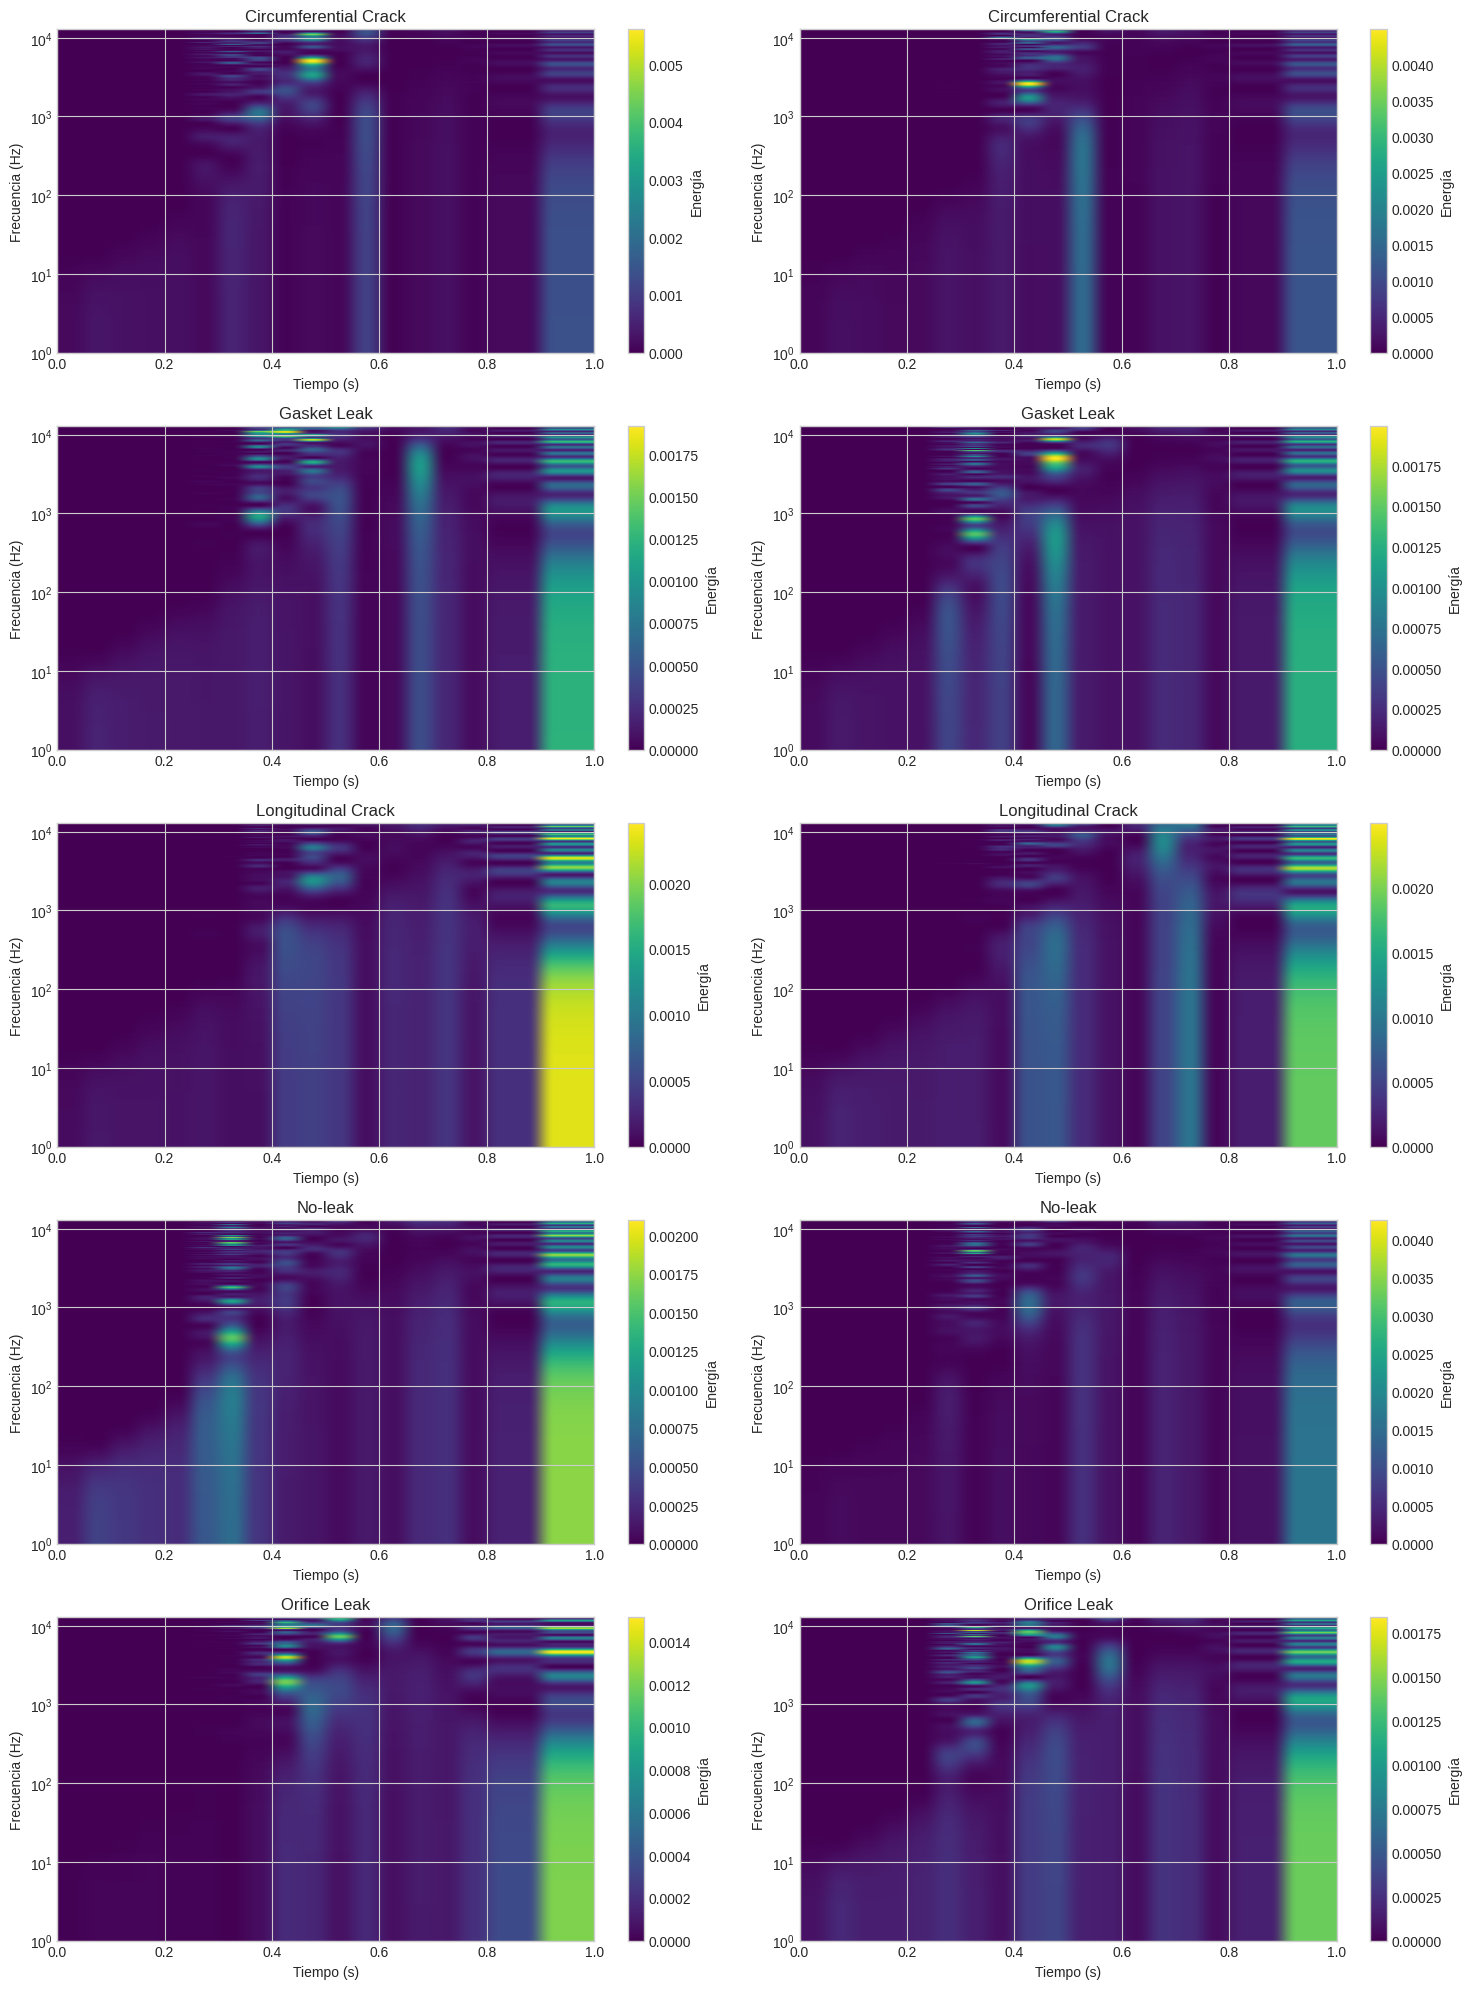

In [ ]:
# Función para calcular la CWT sin segmentación
def calculate_cwt_full(signal, fs=25600, f0=1.0, f1=None, fn=20, sigma=6.0, fast=True, norm=True, scaling="log", nthreads=8):
    """
    Calcula la CWT de una señal completa utilizando la biblioteca fCWT con manejo del COI.

    Args:
        signal: Señal de entrada.
        fs: Frecuencia de muestreo.
        f0: Frecuencia mínima.
        f1: Frecuencia máxima.
        fn: Número de escalas.
        sigma: Parámetro sigma para la wavelet Morlet.
        fast: Modo rápido.
        norm: Normalización.
        scaling: Tipo de escalado ("log" o "linear").
        nthreads: Número de hilos.

    Returns:
        freqs_array: Array de frecuencias.
        cwt_output: Coeficientes de la CWT.
        coi_mask: Máscara del Cone of Influence (COI).
        scales_array: Array de escalas.
    """
    signal = np.array(signal, dtype=np.float32)

    if f1 is None:
        f1 = fs / 2

    morlet = fcwt.Morlet(sigma)

    if scaling.lower() == "log":
        scale_type = fcwt.FCWT_LOGSCALES
    else:
        scale_type = fcwt.FCWT_LINFREQS

    scales_obj = fcwt.Scales(morlet, scale_type, fs, f0, f1, fn)

    scales_array = np.zeros(fn, dtype=np.float32)
    freqs_array = np.zeros(fn, dtype=np.float32)

    scales_obj.getScales(scales_array)
    scales_obj.getFrequencies(freqs_array)

    fcwt_obj = fcwt.FCWT(morlet, nthreads, fast, norm)

    cwt_output = np.zeros((fn, len(signal)), dtype=np.complex64)

    fcwt_obj.cwt(signal, scales_obj, cwt_output)

    coi_mask = calculate_coi_mask(cwt_output, scales_array, len(signal), sigma)

    return freqs_array, cwt_output, coi_mask, scales_array

# Función para calcular la máscara del COI
def calculate_coi_mask(cwt_output, scales, signal_length, sigma=6.0):
    """
    Calcula la máscara del Cone of Influence (COI) para un escalograma CWT.

    Args:
        cwt_output: Coeficientes de la CWT.
        scales: Array de escalas.
        signal_length: Longitud de la señal.
        sigma: Parámetro sigma para la wavelet Morlet.

    Returns:
        mask: Máscara del COI.
    """
    mask = np.ones_like(cwt_output, dtype=bool)

    for i in range(len(scales)):
        scale = scales[i]
        border_width = int(np.ceil(sigma * np.sqrt(2) * scale))
        border_width = min(border_width, signal_length // 2)

        if border_width > 0:
            mask[i, :border_width] = False
            mask[i, -border_width:] = False

    return mask

# Función para calcular escalogramas CWT para señales completas
def get_cwt_features_full(signals, labels, fs=25600, f0=1.0, f1=None, fn=20, sigma=6.0, nthreads=8, scaling="log", fast=True, norm=True):
    """
    Calcula escalogramas CWT para señales completas usando fCWT con aplicación de la máscara del COI.

    Args:
        signals: Lista de señales.
        labels: Lista de etiquetas correspondientes.
        fs: Frecuencia de muestreo.
        f0: Frecuencia mínima.
        f1: Frecuencia máxima.
        fn: Número de escalas.
        sigma: Parámetro sigma para la wavelet Morlet.
        nthreads: Número de hilos.
        scaling: Tipo de escalado ("log" o "linear").
        fast: Modo rápido.
        norm: Normalización.

    Returns:
        scalograms: Lista de escalogramas.
        labels: Lista de etiquetas correspondientes.
        coi_percentages: Porcentajes de área afectada por el COI.
    """
    if f1 is None:
        f1 = fs / 2

    scalograms = []
    coi_percentages = []

    for i, signal in enumerate(tqdm(signals, desc="Calculando CWT para señales completas")):
        try:
            freqs, cwt_coef, coi_mask, scales = calculate_cwt_full(signal, fs, f0, f1, fn, sigma, fast, norm, scaling, nthreads)

            valid_percentage = np.mean(coi_mask) * 100
            coi_percentages.append(valid_percentage)

            scalogram_full = np.square(np.abs(cwt_coef)).T

            scalograms.append(scalogram_full)

        except Exception as e:
            print(f"Error en señal {i}: {e}")
            continue

    return scalograms, labels, coi_percentages

# Calcular escalogramas CWT para señales completas
train_scalograms_full, train_labels, train_coi_percentages = get_cwt_features_full(
    wavelet_denoised_signals_dict['training'],
    labels_dict['training'],
    fn=20,
    sigma=6.0,
    scaling="log",
    nthreads=1
)

test_scalograms_full, test_labels, test_coi_percentages = get_cwt_features_full(
    wavelet_denoised_signals_dict['testing'],
    labels_dict['testing'],
    fn=20,
    sigma=6.0,
    scaling="log",
    nthreads=1
)

# Visualizar algunos escalogramas completos
def plot_cwt_scalograms_full(scalograms, labels, label_codes_dict, num_per_class=2, fs=25600):
    """
    Visualiza escalogramas CWT completos.

    Args:
        scalograms: Lista de escalogramas.
        labels: Lista de etiquetas correspondientes.
        label_codes_dict: Diccionario de códigos de etiquetas.
        num_per_class: Número de escalogramas a mostrar por clase.
        fs: Frecuencia de muestreo (Hz).
    """
    t_duration = len(scalograms[0]) / fs
    f0 = 1.0
    f1 = fs / 2

    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    rows = num_classes
    cols = num_per_class

    plt.figure(figsize=(15, 4 * rows))

    for i, label_code in enumerate(unique_labels):
        class_indices = [idx for idx, l in enumerate(labels) if l == label_code]

        if len(class_indices) == 0:
            continue

        selected_indices = random.sample(class_indices, min(num_per_class, len(class_indices)))

        for j, idx in enumerate(selected_indices):
            if 'classification_mode' in globals() and globals()['classification_mode'] == 'five_classes':
                label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(label_code)]
            else:
                label_name = 'Leak' if label_code == 0 else 'No-leak'

            ax = plt.subplot(rows, cols, i * cols + j + 1)
            im = ax.imshow(scalograms[idx], aspect='auto', origin='lower', extent=[0, t_duration, f0, f1], cmap=cm.viridis)
            ax.set_yscale('log')
            ax.set_title(f"{label_name}")
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Frecuencia (Hz)')
            plt.colorbar(im, ax=ax, label='Energía')

    plt.tight_layout()
    plt.show()

# Visualizar escalogramas completos
plot_cwt_scalograms_full(train_scalograms_full, train_labels, label_codes_dict, num_per_class=2)

# Procesamiento de Escalogramas - Creación de ELIS
Implementación de la técnica Enhanced Log-scaled Intensity Scalogram (ELIS) para mejorar la visualización y representación de los escalogramas CWT completos, aplicando realce adaptativo de características.

Creando ELIS para escalogramas completos:   0%|          | 0/960 [00:00<?, ?it/s]

Creando ELIS para escalogramas completos:   0%|          | 0/240 [00:00<?, ?it/s]

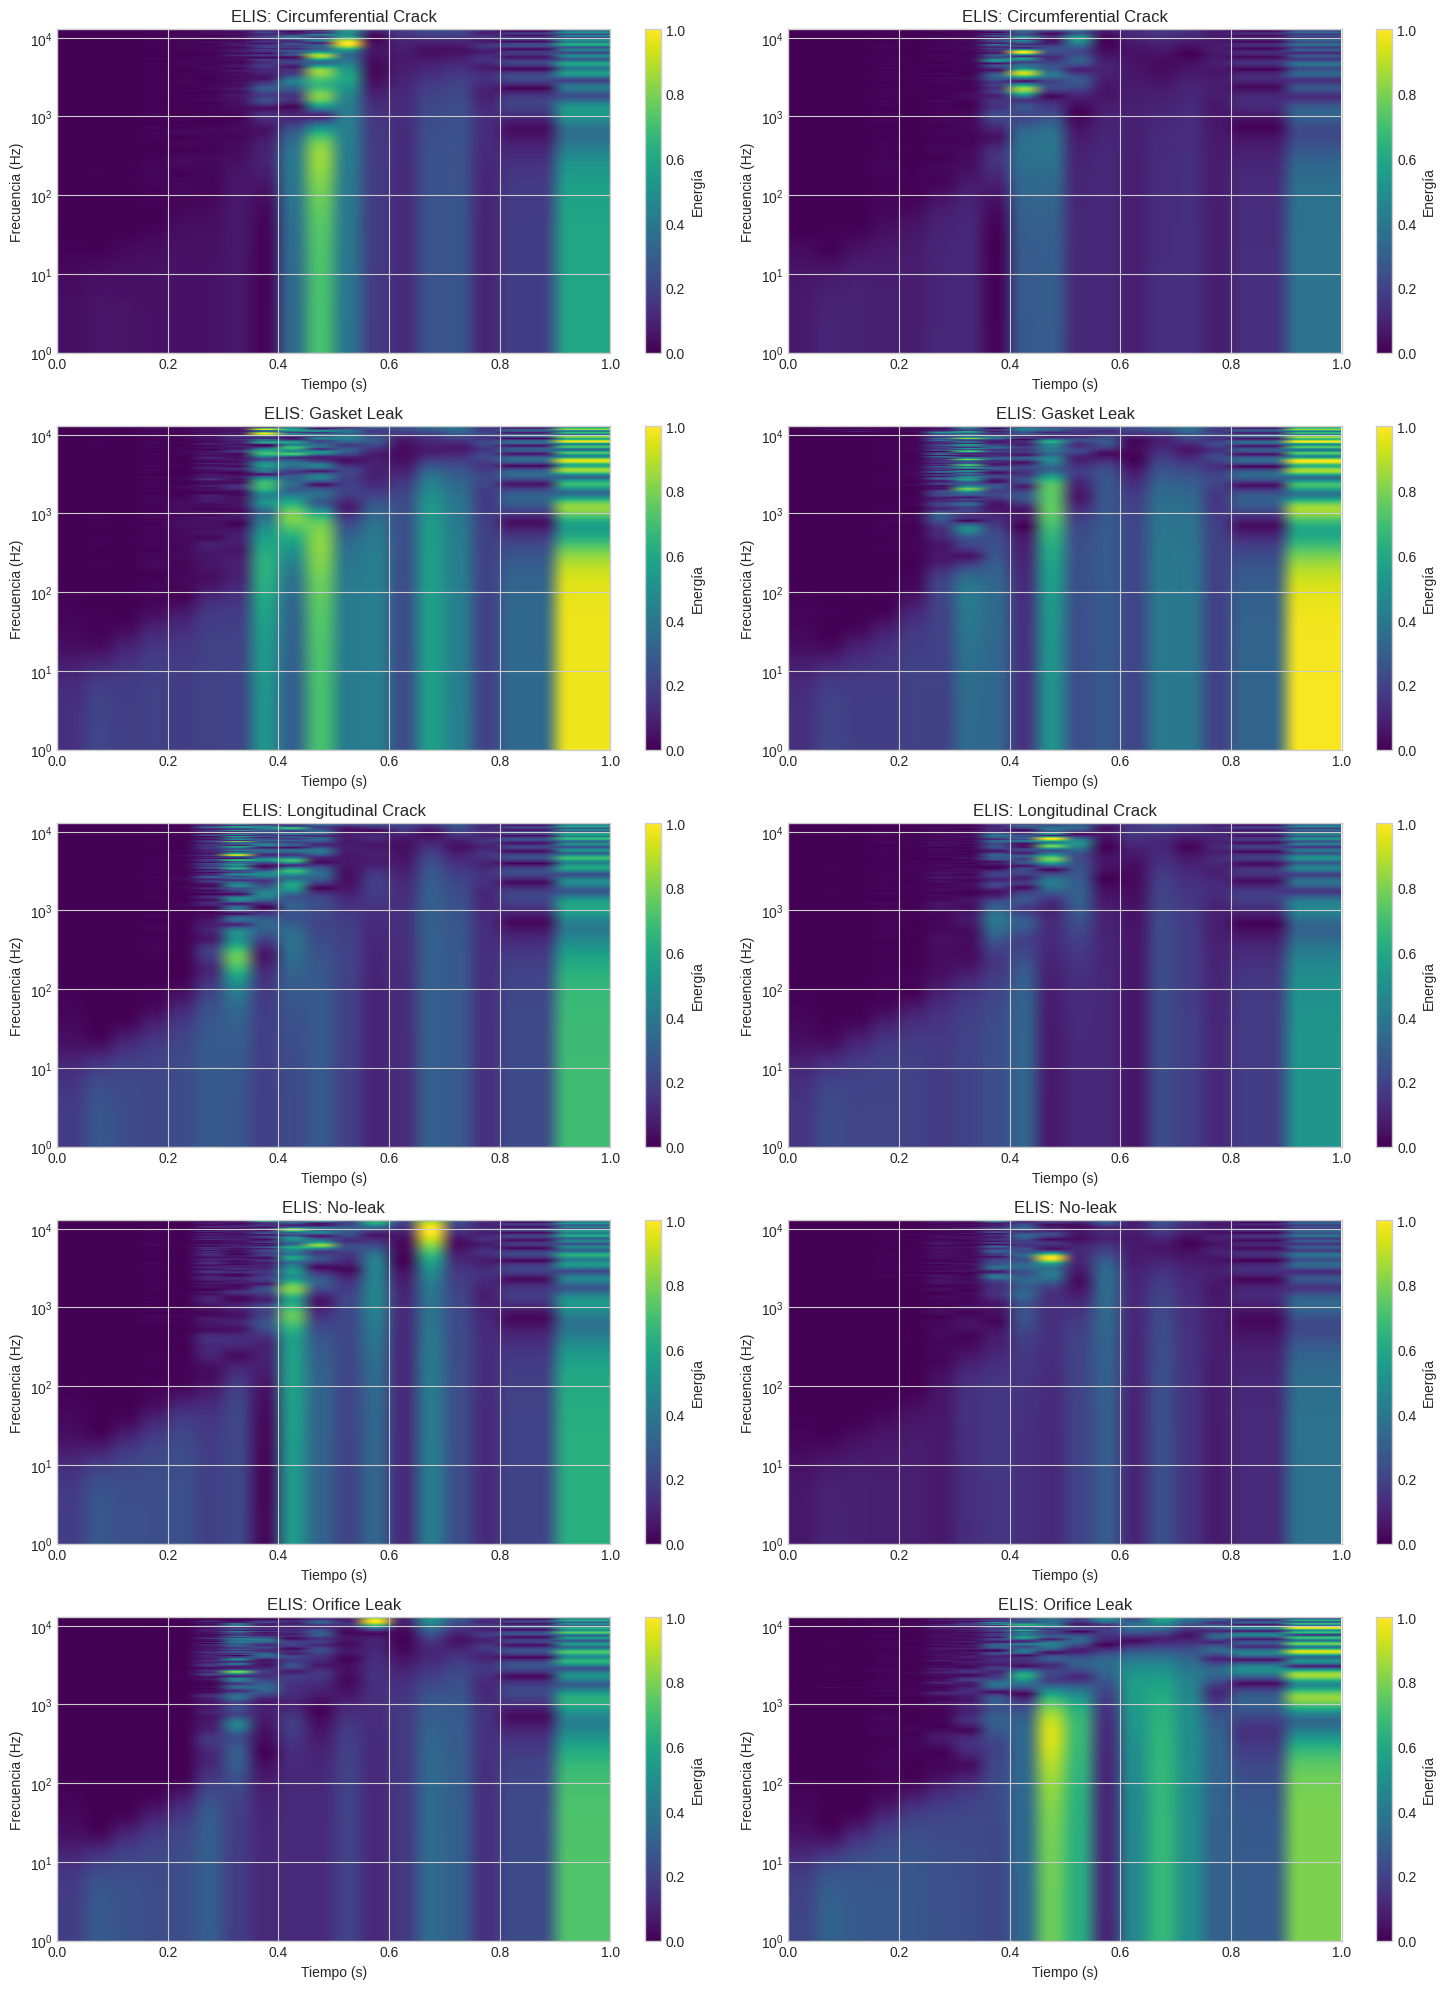

In [ ]:
# Función para crear ELIS (Enhanced Log-scaled Intensity Scalogram) para escalogramas completos
def create_elis_full(scalograms, alpha=0.5, beta=0.5):
    """
    Aplica la técnica ELIS a una lista de escalogramas completos.

    Args:
        scalograms: Lista de escalogramas originales.
        alpha: Parámetro de realce adaptativo.
        beta: Parámetro de ajuste de intensidad.

    Returns:
        Lista de escalogramas ELIS.
    """
    elis_scalograms = []

    for scalogram in tqdm(scalograms, desc="Creando ELIS para escalogramas completos"):
        # Aplicar logaritmo para escalar la intensidad
        log_scaled = np.log1p(scalogram)

        # Realce adaptativo
        enhanced = alpha * log_scaled + beta * np.sqrt(log_scaled)

        # Normalizar entre 0 y 1
        min_val = np.min(enhanced)
        max_val = np.max(enhanced)
        if max_val > min_val:
            normalized = (enhanced - min_val) / (max_val - min_val)
        else:
            normalized = np.zeros_like(enhanced)

        elis_scalograms.append(normalized)

    return elis_scalograms

# Aplicar ELIS a los escalogramas completos de entrenamiento y prueba
train_elis_scalograms_full = create_elis_full(train_scalograms_full)
test_elis_scalograms_full = create_elis_full(test_scalograms_full)

# Visualizar algunos escalogramas ELIS completos
def plot_elis_scalograms_full(elis_scalograms, labels, label_codes_dict, num_per_class=2, fs=25600):
    """
    Visualiza escalogramas ELIS completos.

    Args:
        elis_scalograms: Lista de escalogramas ELIS.
        labels: Lista de etiquetas correspondientes.
        label_codes_dict: Diccionario de códigos de etiquetas.
        num_per_class: Número de escalogramas a mostrar por clase.
        fs: Frecuencia de muestreo (Hz).
    """
    t_duration = len(elis_scalograms[0]) / fs
    f0 = 1.0
    f1 = fs / 2

    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    rows = num_classes
    cols = num_per_class

    plt.figure(figsize=(15, 4 * rows))

    for i, label_code in enumerate(unique_labels):
        class_indices = [idx for idx, l in enumerate(labels) if l == label_code]

        if len(class_indices) == 0:
            continue

        selected_indices = random.sample(class_indices, min(num_per_class, len(class_indices)))

        for j, idx in enumerate(selected_indices):
            if 'classification_mode' in globals() and globals()['classification_mode'] == 'five_classes':
                label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(label_code)]
            else:
                label_name = 'Leak' if label_code == 0 else 'No-leak'

            ax = plt.subplot(rows, cols, i * cols + j + 1)
            im = ax.imshow(elis_scalograms[idx], aspect='auto', origin='lower', extent=[0, t_duration, f0, f1], cmap=cm.viridis)
            ax.set_yscale('log')
            ax.set_title(f"ELIS: {label_name}")
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Frecuencia (Hz)')
            plt.colorbar(im, ax=ax, label='Energía')

    plt.tight_layout()
    plt.show()

# Visualizar escalogramas ELIS completos
plot_elis_scalograms_full(train_elis_scalograms_full, train_labels, label_codes_dict, num_per_class=2)

# Segmentación de Escalogramas para Entrenamiento
División de los escalogramas completos en segmentos más pequeños para alimentar al modelo de clasificación, manteniendo la misma etiqueta para todos los segmentos de un mismo escalograma. Implementación de funciones para visualizar la segmentación y preparar los datos para el entrenamiento.

Segmentando escalogramas:   0%|          | 0/960 [00:00<?, ?it/s]

Segmentando escalogramas:   0%|          | 0/240 [00:00<?, ?it/s]

Liberando memoria RAM...
Uso de memoria antes: 9714.12 MB
Uso de memoria después: 6483.56 MB
Memoria liberada: 3230.56 MB
Segmentos de entrenamiento: (96000, 256, 20, 1)
Segmentos de prueba: (24000, 256, 20, 1)
Etiquetas de entrenamiento: (96000,)
Etiquetas de prueba: (24000,)


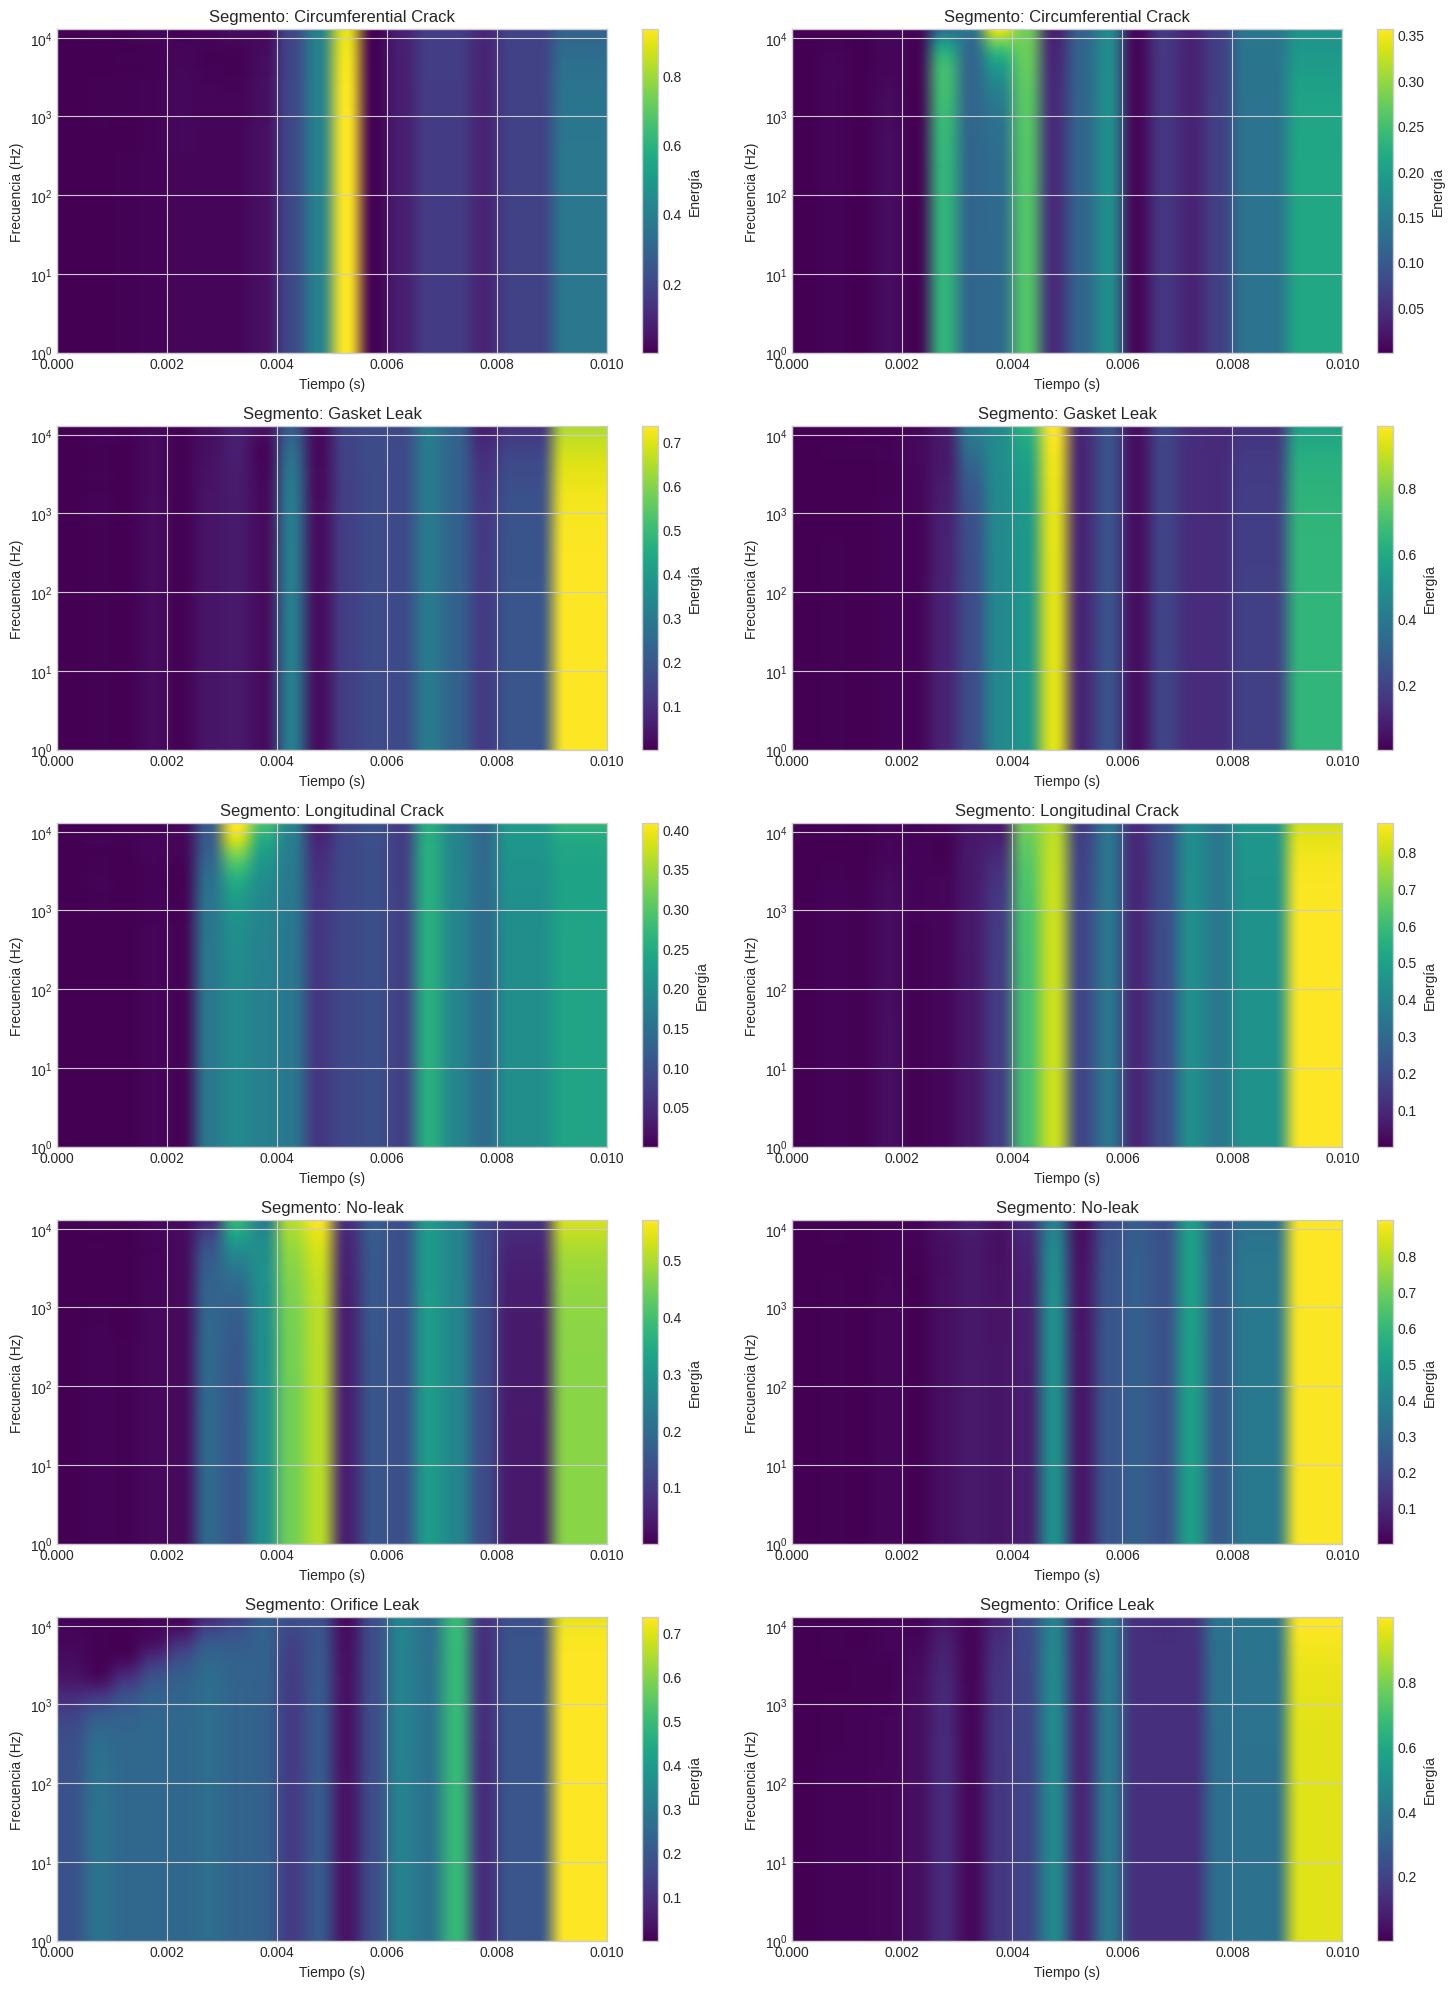

In [ ]:
# Función para segmentar escalogramas completos en segmentos más pequeños
def segment_scalograms(scalograms, labels, segment_size):
    """
    Segmenta escalogramas completos en segmentos más pequeños para entrenamiento.

    Args:
        scalograms: Lista de escalogramas completos.
        labels: Lista de etiquetas correspondientes.
        segment_size: Tamaño de cada segmento (en muestras).

    Returns:
        segmented_scalograms: Lista de segmentos de escalogramas.
        segmented_labels: Lista de etiquetas correspondientes a los segmentos.
    """
    segmented_scalograms = []
    segmented_labels = []

    for i, scalogram in enumerate(tqdm(scalograms, desc="Segmentando escalogramas")):
        num_segments = scalogram.shape[0] // segment_size

        for j in range(num_segments):
            segment = scalogram[j * segment_size:(j + 1) * segment_size, :]
            segmented_scalograms.append(segment)
            segmented_labels.append(labels[i])  # Mantener la misma etiqueta para todos los segmentos

    return np.array(segmented_scalograms), np.array(segmented_labels)

# Segmentar escalogramas ELIS completos para entrenamiento y prueba
segment_size = 256  # Tamaño de cada segmento en muestras
train_elis_segments, train_segment_labels = segment_scalograms(train_elis_scalograms_full, train_labels, segment_size)
test_elis_segments, test_segment_labels = segment_scalograms(test_elis_scalograms_full, test_labels, segment_size)

# Liberar memoria eliminando las variables grandes que ya no se necesitan
print("Liberando memoria RAM...")
import gc
import psutil

# Guardar el uso de memoria antes de la limpieza
proceso = psutil.Process()
memoria_antes = proceso.memory_info().rss / 1024 / 1024  # Convertir a MB
print(f"Uso de memoria antes: {memoria_antes:.2f} MB")

# Eliminar las variables grandes
del train_elis_scalograms_full
del test_elis_scalograms_full
del train_scalograms_full
del test_scalograms_full
del wavelet_denoised_signals_dict
del normalized_signals_dict
del signals_dict

# Si estas variables aún existen, también eliminarlas
if 'signals_lst' in globals():
    del signals_lst
if 'labels_lst' in globals():
    del labels_lst

# Forzar la recolección de basura
gc.collect()

# Verificar el nuevo uso de memoria
memoria_despues = proceso.memory_info().rss / 1024 / 1024  # Convertir a MB
print(f"Uso de memoria después: {memoria_despues:.2f} MB")
print(f"Memoria liberada: {memoria_antes - memoria_despues:.2f} MB")

# Añadir dimensión de canal a los segmentos
train_elis_segments = train_elis_segments[..., np.newaxis]
test_elis_segments = test_elis_segments[..., np.newaxis]

# Imprimir información sobre los datos segmentados
print(f"Segmentos de entrenamiento: {train_elis_segments.shape}")
print(f"Segmentos de prueba: {test_elis_segments.shape}")
print(f"Etiquetas de entrenamiento: {train_segment_labels.shape}")
print(f"Etiquetas de prueba: {test_segment_labels.shape}")

# Visualizar algunos segmentos de escalogramas
def plot_segmented_scalograms(segments, labels, label_codes_dict, num_per_class=2, fs=25600, segment_size=256):
    """
    Visualiza segmentos de escalogramas.

    Args:
        segments: Lista de segmentos de escalogramas.
        labels: Lista de etiquetas correspondientes.
        label_codes_dict: Diccionario de códigos de etiquetas.
        num_per_class: Número de segmentos a mostrar por clase.
        fs: Frecuencia de muestreo (Hz).
        segment_size: Tamaño del segmento en muestras.
    """
    t_duration = segment_size / fs
    f0 = 1.0
    f1 = fs / 2

    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    rows = num_classes
    cols = num_per_class

    plt.figure(figsize=(15, 4 * rows))

    for i, label_code in enumerate(unique_labels):
        class_indices = [idx for idx, l in enumerate(labels) if l == label_code]

        if len(class_indices) == 0:
            continue

        selected_indices = random.sample(class_indices, min(num_per_class, len(class_indices)))

        for j, idx in enumerate(selected_indices):
            if 'classification_mode' in globals() and globals()['classification_mode'] == 'five_classes':
                label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(label_code)]
            else:
                label_name = 'Leak' if label_code == 0 else 'No-leak'

            ax = plt.subplot(rows, cols, i * cols + j + 1)
            im = ax.imshow(segments[idx].squeeze(), aspect='auto', origin='lower', extent=[0, t_duration, f0, f1], cmap=cm.viridis)
            ax.set_yscale('log')
            ax.set_title(f"Segmento: {label_name}")
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Frecuencia (Hz)')
            plt.colorbar(im, ax=ax, label='Energía')

    plt.tight_layout()
    plt.show()

# Visualizar segmentos de escalogramas
plot_segmented_scalograms(train_elis_segments, train_segment_labels, label_codes_dict, num_per_class=2)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm
from IPython.display import display
# Montar Google Drive (para Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Guardar y Cargar Datasets
Funciones para guardar los escalogramas procesados completos y sus segmentos en formato HDF5 en Google Drive y cargarlos posteriormente. División de datos en conjuntos de entrenamiento, validación y prueba.

In [ ]:
# Función para guardar datasets procesados en formato HDF5
def save_elis_dataset(file_path, x_train, y_train, x_test, y_test, classification_mode, label_codes_dict=None):
    """
    Guarda el dataset de escalogramas ELIS procesados en formato HDF5.

    Args:
        file_path: Ruta del archivo HDF5 donde se guardará el dataset.
        x_train: Segmentos de escalogramas ELIS de entrenamiento.
        y_train: Etiquetas de entrenamiento.
        x_test: Segmentos de escalogramas ELIS de prueba.
        y_test: Etiquetas de prueba.
        classification_mode: Modo de clasificación ('five_classes' o 'binary').
        label_codes_dict: Diccionario de códigos de etiquetas (opcional).
    """
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Determinar número de clases
    num_classes = 5 if classification_mode == 'five_classes' else 2

    # Dividir conjunto de entrenamiento para crear un conjunto de validación
    val_split = 0.2
    val_indices = np.random.choice(len(x_train), int(len(x_train) * val_split), replace=False)
    train_mask = np.ones(len(x_train), dtype=bool)
    train_mask[val_indices] = False

    # Dividir los datos de entrenamiento en entrenamiento y validación
    x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=0.2,
    stratify=y_train,  # Para mantener la proporción de clases
    random_state=42
)


    # Convertir etiquetas a one-hot
    y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
    y_val_onehot = keras.utils.to_categorical(y_val, num_classes)
    y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

    # Guardar en formato HDF5
    with h5py.File(file_path, 'w') as hf:
        train_group = hf.create_group('train')
        val_group = hf.create_group('val')
        test_group = hf.create_group('test')
        metadata_group = hf.create_group('metadata')

        train_group.create_dataset('x_train', data=x_train)
        train_group.create_dataset('y_train', data=y_train)
        train_group.create_dataset('y_train_onehot', data=y_train_onehot)

        val_group.create_dataset('x_val', data=x_val)
        val_group.create_dataset('y_val', data=y_val)
        val_group.create_dataset('y_val_onehot', data=y_val_onehot)

        test_group.create_dataset('x_test', data=x_test)
        test_group.create_dataset('y_test', data=y_test)
        test_group.create_dataset('y_test_onehot', data=y_test_onehot)

        metadata_group.attrs['num_classes'] = num_classes
        metadata_group.attrs['classification_mode'] = classification_mode

    # Guardar diccionario de etiquetas en un archivo de texto
    if label_codes_dict is not None:
        classes_file = file_path.replace('.h5', '_classes.txt')
        with open(classes_file, 'w') as f:
            for name, code in label_codes_dict.items():
                f.write(f"{name}: {code}\n")

    print(f"Dataset guardado en: {file_path}")

# Guardar el dataset ELIS segmentado en Google Drive
elis_dataset_path = '/content/drive/MyDrive/Tesis/ELIS_Dataset/elis_segmented_dataset.h5'
#save_elis_dataset(elis_dataset_path, train_elis_segments, train_segment_labels, test_elis_segments, test_segment_labels, classification_mode, label_codes_dict)

# Función para cargar datasets procesados desde formato HDF5
def load_elis_dataset(file_path):
    """
    Carga un dataset de escalogramas ELIS desde un archivo HDF5.

    Args:
        file_path: Ruta del archivo HDF5.

    Returns:
        Diccionario con los datos de entrenamiento, validación y prueba.
    """
    with h5py.File(file_path, 'r') as hf:
        x_train = np.array(hf['train']['x_train'])
        y_train = np.array(hf['train']['y_train'])
        y_train_onehot = np.array(hf['train']['y_train_onehot'])

        x_val = np.array(hf['val']['x_val'])
        y_val = np.array(hf['val']['y_val'])
        y_val_onehot = np.array(hf['val']['y_val_onehot'])

        x_test = np.array(hf['test']['x_test'])
        y_test = np.array(hf['test']['y_test'])
        y_test_onehot = np.array(hf['test']['y_test_onehot'])

        num_classes = hf['metadata'].attrs['num_classes']
        classification_mode = hf['metadata'].attrs['classification_mode']

    print(f"Dataset cargado desde: {file_path}")
    print(f"- Número de clases: {num_classes}")
    print(f"- Modo de clasificación: {classification_mode}")
    print(f"- Muestras de entrenamiento: {len(x_train)}")
    print(f"- Muestras de validación: {len(x_val)}")
    print(f"- Muestras de prueba: {len(x_test)}")

    return {
        'x_train': x_train,
        'y_train': y_train,
        'y_train_onehot': y_train_onehot,
        'x_val': x_val,
        'y_val': y_val,
        'y_val_onehot': y_val_onehot,
        'x_test': x_test,
        'y_test': y_test,
        'y_test_onehot': y_test_onehot
    }

# Cargar el dataset ELIS segmentado desde Google Drive
elis_segmented_dataset = load_elis_dataset(elis_dataset_path)
# Reconstruir el diccionario de etiquetas a partir de los datos cargados
y_test_raw = elis_segmented_dataset['y_test']
num_classes = elis_segmented_dataset['y_train_onehot'].shape[1]

# Definir el diccionario de etiquetas según el número de clases
if num_classes == 5:  # Five classes
    label_codes_dict = {
        'Circumferential Crack': 0,
        'Gasket Leak': 1,
        'Longitudinal Crack': 2,
        'No-leak': 3,
        'Orifice Leak': 4
    }
else:  # Binary classification
    label_codes_dict = {'Leak': 0, 'No-leak': 1}

# Verificar que el diccionario se ha reconstruido correctamente
print("Diccionario de etiquetas reconstruido:")
print(label_codes_dict)

Dataset cargado desde: /content/drive/MyDrive/Tesis/ELIS_Dataset/elis_segmented_dataset.h5
- Número de clases: 5
- Modo de clasificación: five_classes
- Muestras de entrenamiento: 76800
- Muestras de validación: 19200
- Muestras de prueba: 24000
Diccionario de etiquetas reconstruido:
{'Circumferential Crack': 0, 'Gasket Leak': 1, 'Longitudinal Crack': 2, 'No-leak': 3, 'Orifice Leak': 4}


# Implementación del Modelo ResNet-18
Implementación de una arquitectura ResNet-18 adaptada para clasificación de segmentos de escalogramas, con técnicas de regularización como dropout y regularización L2 para prevenir el sobreajuste. Entrenamiento del modelo con los segmentos de escalogramas y evaluación sobre el conjunto de prueba.

In [ ]:
# Implementación del modelo ResNet-18 adaptado para clasificación de segmentos de escalogramas ELIS
def build_resnet18(input_shape, num_classes):
    """
    Construye un modelo ResNet-18 adaptado para clasificación de segmentos de escalogramas.

    Args:
        input_shape: Forma de entrada de los datos (altura, ancho, canales).
        num_classes: Número de clases para la clasificación.

    Returns:
        Modelo ResNet-18 compilado.
    """
    inputs = keras.Input(shape=input_shape)

    # Primera capa de convolución
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same", kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    # Bloques residuales
    def residual_block(x, filters, downsample=False):
        identity = x
        stride = (2, 2) if downsample else (1, 1)

        x = layers.Conv2D(filters, (3, 3), strides=stride, padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, (3, 3), strides=(1, 1), padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)

        if downsample:
            identity = layers.Conv2D(filters, (1, 1), strides=stride, padding="same", kernel_regularizer=regularizers.l2(1e-4))(identity)
            identity = layers.BatchNormalization()(identity)

        x = layers.add([x, identity])
        x = layers.ReLU()(x)
        return x

    # Construcción de bloques residuales
    for filters, blocks, downsample in zip([64, 128, 256, 512], [2, 2, 2, 2], [False, True, True, True]):
        for _ in range(blocks):
            x = residual_block(x, filters, downsample)
            downsample = False  # Solo el primer bloque de cada etapa realiza downsampling

    # Capa final
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Dropout para regularización
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer=regularizers.l2(1e-4))(x)

    model = keras.Model(inputs, outputs)
    return model

# Cargar los datos del dataset ELIS segmentado
x_train, y_train = elis_segmented_dataset['x_train'], elis_segmented_dataset['y_train_onehot']
x_val, y_val = elis_segmented_dataset['x_val'], elis_segmented_dataset['y_val_onehot']
x_test, y_test = elis_segmented_dataset['x_test'], elis_segmented_dataset['y_test_onehot']

# Verificar la forma de los datos
print(f"Forma de los datos de entrenamiento: {x_train.shape}")
print(f"Forma de las etiquetas de entrenamiento: {y_train.shape}")

# Construir el modelo ResNet-18
input_shape = x_train.shape[1:]  # Forma de entrada de los datos
num_classes = y_train.shape[1]  # Número de clases
resnet18_model = build_resnet18(input_shape, num_classes)

# Compilar el modelo
resnet18_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Configurar callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=8, min_lr=1e-6),
    ModelCheckpoint(filepath="/content/drive/MyDrive/Tesis/ELIS_Dataset/elis_segmented_model.h5", save_best_only=True, monitor="val_loss")
]

# Entrenar el modelo
history = resnet18_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=callbacks
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = resnet18_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualizar las métricas de entrenamiento
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Generar reporte de clasificación
y_pred = np.argmax(resnet18_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_codes_dict.keys())))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_codes_dict.keys()), yticklabels=list(label_codes_dict.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Forma de los datos de entrenamiento: (76800, 256, 20, 1)
Forma de las etiquetas de entrenamiento: (76800, 5)
Epoch 1/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3867 - loss: 1.9209

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 105s 32ms/step - accuracy: 0.3867 - loss: 1.9206 - val_accuracy: 0.4128 - val_loss: 1.6064 - learning_rate: 0.0010
Epoch 2/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5183 - loss: 1.3410

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 127s 32ms/step - accuracy: 0.5183 - loss: 1.3410 - val_accuracy: 0.4804 - val_loss: 1.5365 - learning_rate: 0.0010
Epoch 3/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5593 - loss: 1.2137

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.5593 - loss: 1.2137 - val_accuracy: 0.5668 - val_loss: 1.2052 - learning_rate: 0.0010
Epoch 4/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 78s 31ms/step - accuracy: 0.5828 - loss: 1.1757 - val_accuracy: 0.5705 - val_loss: 1.2225 - learning_rate: 0.0010
Epoch 5/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5946 - loss: 1.1610

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.5946 - loss: 1.1609 - val_accuracy: 0.5997 - val_loss: 1.1331 - learning_rate: 0.0010
Epoch 6/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6152 - loss: 1.0932

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 86s 33ms/step - accuracy: 0.6152 - loss: 1.0932 - val_accuracy: 0.6103 - val_loss: 1.1091 - learning_rate: 0.0010
Epoch 7/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6227 - loss: 1.0685

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 78s 32ms/step - accuracy: 0.6227 - loss: 1.0685 - val_accuracy: 0.6097 - val_loss: 1.1040 - learning_rate: 0.0010
Epoch 8/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6313 - loss: 1.0363

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.6313 - loss: 1.0363 - val_accuracy: 0.6376 - val_loss: 1.0111 - learning_rate: 0.0010
Epoch 9/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step - accuracy: 0.6438 - loss: 1.0130 - val_accuracy: 0.6294 - val_loss: 1.0380 - learning_rate: 0.0010
Epoch 10/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6474 - loss: 0.9962

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 78s 32ms/step - accuracy: 0.6474 - loss: 0.9962 - val_accuracy: 0.6671 - val_loss: 0.9559 - learning_rate: 0.0010
Epoch 11/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 76s 30ms/step - accuracy: 0.6621 - loss: 0.9634 - val_accuracy: 0.6534 - val_loss: 0.9710 - learning_rate: 0.0010
Epoch 12/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6643 - loss: 0.9607

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 88s 33ms/step - accuracy: 0.6643 - loss: 0.9607 - val_accuracy: 0.6603 - val_loss: 0.9551 - learning_rate: 0.0010
Epoch 13/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step - accuracy: 0.6675 - loss: 0.9485 - val_accuracy: 0.6497 - val_loss: 0.9733 - learning_rate: 0.0010
Epoch 14/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 71s 30ms/step - accuracy: 0.6762 - loss: 0.9298 - val_accuracy: 0.6423 - val_loss: 1.0146 - learning_rate: 0.0010
Epoch 15/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 71s 30ms/step - accuracy: 0.6793 - loss: 0.9264 - val_accuracy: 0.6573 - val_loss: 0.9672 - learning_rate: 0.0010
Epoch 16/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6821 - loss: 0.9193

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 87s 32ms/step - accuracy: 0.6821 - loss: 0.9193 - val_accuracy: 0.6742 - val_loss: 0.9321 - learning_rate: 0.0010
Epoch 17/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6901 - loss: 0.9092

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 76s 32ms/step - accuracy: 0.6901 - loss: 0.9092 - val_accuracy: 0.6871 - val_loss: 0.9037 - learning_rate: 0.0010
Epoch 18/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 71s 30ms/step - accuracy: 0.6968 - loss: 0.8968 - val_accuracy: 0.6684 - val_loss: 0.9667 - learning_rate: 0.0010
Epoch 19/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.6956 - loss: 0.9002 - val_accuracy: 0.6817 - val_loss: 0.9340 - learning_rate: 0.0010
Epoch 20/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.6997 - loss: 0.8863 - val_accuracy: 0.6818 - val_loss: 0.9177 - learning_rate: 0.0010
Epoch 21/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accuracy: 0.7047 - loss: 0.8820 - val_accuracy: 0.6794 - val_loss: 0.9223 - learning_rate: 0.0010
Epoch 22/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 71s 29ms/step - accuracy: 0.7070 - loss: 0.8734 - val_accuracy: 0.6784 - val_loss: 0.9490 - learning_rate: 0.0010
Epoch 23/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accur

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 91s 33ms/step - accuracy: 0.7576 - loss: 0.7577 - val_accuracy: 0.7477 - val_loss: 0.7746 - learning_rate: 2.0000e-04
Epoch 27/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7761 - loss: 0.6972

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 78s 32ms/step - accuracy: 0.7761 - loss: 0.6972 - val_accuracy: 0.7500 - val_loss: 0.7628 - learning_rate: 2.0000e-04
Epoch 28/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7874 - loss: 0.6704

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 84s 32ms/step - accuracy: 0.7874 - loss: 0.6704 - val_accuracy: 0.7557 - val_loss: 0.7538 - learning_rate: 2.0000e-04
Epoch 29/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7955 - loss: 0.6525

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 76s 32ms/step - accuracy: 0.7954 - loss: 0.6525 - val_accuracy: 0.7581 - val_loss: 0.7429 - learning_rate: 2.0000e-04
Epoch 30/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7978 - loss: 0.6376

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.7978 - loss: 0.6376 - val_accuracy: 0.7619 - val_loss: 0.7388 - learning_rate: 2.0000e-04
Epoch 31/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8028 - loss: 0.6223

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 85s 33ms/step - accuracy: 0.8028 - loss: 0.6224 - val_accuracy: 0.7620 - val_loss: 0.7236 - learning_rate: 2.0000e-04
Epoch 32/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 71s 30ms/step - accuracy: 0.8049 - loss: 0.6142 - val_accuracy: 0.7648 - val_loss: 0.7238 - learning_rate: 2.0000e-04
Epoch 33/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8094 - loss: 0.6013

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 84s 30ms/step - accuracy: 0.8094 - loss: 0.6013 - val_accuracy: 0.7688 - val_loss: 0.7097 - learning_rate: 2.0000e-04
Epoch 34/200
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8133 - loss: 0.5909

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 77s 32ms/step - accuracy: 0.8133 - loss: 0.5909 - val_accuracy: 0.7710 - val_loss: 0.7091 - learning_rate: 2.0000e-04
Epoch 35/200
2399/2400 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8167 - loss: 0.5837

2400/2400 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.8167 - loss: 0.5837 - val_accuracy: 0.7722 - val_loss: 0.6995 - learning_rate: 2.0000e-04
Epoch 36/200
1553/2400 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.8214 - loss: 0.5726

## Version con Data augmentation

In [ ]:
# Implementación del modelo ResNet-18 adaptado para clasificación de segmentos de escalogramas ELIS con data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_resnet18(input_shape, num_classes):
    """
    Construye un modelo ResNet-18 adaptado para clasificación de segmentos de escalogramas.

    Args:
        input_shape: Forma de entrada de los datos (altura, ancho, canales).
        num_classes: Número de clases para la clasificación.

    Returns:
        Modelo ResNet-18 compilado.
    """
    inputs = keras.Input(shape=input_shape)

    # Primera capa de convolución
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same", kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    # Bloques residuales
    def residual_block(x, filters, downsample=False):
        identity = x
        stride = (2, 2) if downsample else (1, 1)

        x = layers.Conv2D(filters, (3, 3), strides=stride, padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, (3, 3), strides=(1, 1), padding="same", kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)

        if downsample:
            identity = layers.Conv2D(filters, (1, 1), strides=stride, padding="same", kernel_regularizer=regularizers.l2(1e-4))(identity)
            identity = layers.BatchNormalization()(identity)

        x = layers.add([x, identity])
        x = layers.ReLU()(x)
        return x

    # Construcción de bloques residuales
    for filters, blocks, downsample in zip([64, 128, 256, 512], [2, 2, 2, 2], [False, True, True, True]):
        for _ in range(blocks):
            x = residual_block(x, filters, downsample)
            downsample = False  # Solo el primer bloque de cada etapa realiza downsampling

    # Capa final
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Dropout para regularización
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer=regularizers.l2(1e-4))(x)

    model = keras.Model(inputs, outputs)
    return model

# Cargar los datos del dataset ELIS segmentado
x_train, y_train = elis_segmented_dataset['x_train'], elis_segmented_dataset['y_train_onehot']
x_val, y_val = elis_segmented_dataset['x_val'], elis_segmented_dataset['y_val_onehot']
x_test, y_test = elis_segmented_dataset['x_test'], elis_segmented_dataset['y_test_onehot']

# Verificar la forma de los datos
print(f"Forma de los datos de entrenamiento: {x_train.shape}")
print(f"Forma de las etiquetas de entrenamiento: {y_train.shape}")

# ===== CONFIGURACIÓN DE DATA AUGMENTATION CON IMAGEDATAGENERATOR =====
# Configurar el generador para los datos de entrenamiento
datagen = ImageDataGenerator(
    rotation_range=10,           # Rotación aleatoria en grados
    width_shift_range=0.1,       # Desplazamiento horizontal (simula variaciones de tiempo)
    height_shift_range=0.1,      # Desplazamiento vertical (simula variaciones de frecuencia)
    zoom_range=0.1,              # Zoom aleatorio
    horizontal_flip=False,       # No volteamos horizontalmente para preservar características temporales
    fill_mode='nearest',         # Método para rellenar píxeles nuevos
    preprocessing_function=lambda img: np.clip(img + np.random.normal(0, 0.03, img.shape), 0, 1)  # Ruido gaussiano
)

# Visualizar ejemplos de data augmentation
def visualize_augmentation(x_sample, datagen, num_examples=3):
    """Visualiza ejemplos de data augmentation aplicados a los datos"""
    plt.figure(figsize=(15, 10))

    # Tomar algunas muestras para visualización
    samples_to_show = min(3, len(x_sample))

    for i in range(samples_to_show):
        # Muestra original
        plt.subplot(samples_to_show, 4, i*4 + 1)
        plt.imshow(x_sample[i].reshape(x_sample.shape[1], x_sample.shape[2]),
                  aspect='auto', cmap='viridis')
        plt.title(f"Original {i+1}")
        plt.colorbar()

        # Muestras aumentadas (generamos 3 variaciones)
        sample = x_sample[i:i+1]  # Necesitamos mantener la dimensión de batch
        aug_iter = datagen.flow(sample, batch_size=1)

        for j in range(3):
            plt.subplot(samples_to_show, 4, i*4 + j + 2)
            aug_sample = next(aug_iter)[0]
            plt.imshow(aug_sample.reshape(x_sample.shape[1], x_sample.shape[2]),
                      aspect='auto', cmap='viridis')
            plt.title(f"Aumentada {j+1}")
            plt.colorbar()

    plt.tight_layout()
    plt.show()

# Visualizar algunas muestras con data augmentation
print("Visualizando ejemplos de data augmentation...")
visualize_augmentation(x_train, datagen, num_examples=3)

# Construir el modelo ResNet-18
input_shape = x_train.shape[1:]  # Forma de entrada de los datos
num_classes = y_train.shape[1]  # Número de clases
resnet18_model = build_resnet18(input_shape, num_classes)

# Compilar el modelo
resnet18_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Definir warmup_schedule para la tasa de aprendizaje
def warmup_schedule(epoch, lr):
    warmup_epochs = 5
    init_lr = 1e-6
    target_lr = 0.0005

    if epoch < warmup_epochs:
        return init_lr + (target_lr - init_lr) * epoch / warmup_epochs
    return lr

# Configurar callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    keras.callbacks.LearningRateScheduler(warmup_schedule),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=8, min_lr=1e-6),
    ModelCheckpoint(filepath="/content/drive/MyDrive/Tesis/ELIS_Dataset/elis_segmented_model.h5", save_best_only=True, monitor="val_loss")
]

# Preparar el generador de datos aumentados
train_generator = datagen.flow(x_train, y_train, batch_size=32)

# Entrenar el modelo con data augmentation dinámico
print("Entrenando modelo con data augmentation...")
history = resnet18_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=callbacks,
    verbose=1
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = resnet18_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualizar las métricas de entrenamiento
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Generar reporte de clasificación
y_pred = np.argmax(resnet18_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_codes_dict.keys())))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_codes_dict.keys()), yticklabels=list(label_codes_dict.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Modelo Tiny Transformer

Forma de los datos de entrenamiento: (76800, 256, 20, 1)
Forma de las etiquetas de entrenamiento: (76800, 5)
Forma antes de reshape: (None, 64, 5, 32)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 256, 20, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 128, 10, 16)    │            160 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 128, 10, 16)    │             64 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_28             │ (None, 128, 10, 16)    │              0 │ batch_normalization_8… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 64, 5, 32)      │          4,640 │ activation_28[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 64, 5, 32)      │            128 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_29             │ (None, 64, 5, 32)      │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_8 (Reshape)       │ (None, 320, 32)        │              0 │ activation_29[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 320, 64)        │          2,112 │ reshape_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_6    │ (None, 320, 64)        │         20,480 │ dense_35[0][0]         │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_40 (Dropout)      │ (None, 320, 64)        │              0 │ positional_embedding_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_26    │ (None, 320, 64)        │            128 │ dropout_40[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_10   │ (None, 320, 64)        │         16,640 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_42 (Dropout)      │ (None, 320, 64)        │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_20 (Add)              │ (None, 320, 64)        │              0 │ dropout_40[0][0],      │
│                           │                        │                │ dropout_42[0][0]       │
├──────────────────────

 Total params: 101,381 (396.02 KB)

 Trainable params: 101,285 (395.64 KB)

 Non-trainable params: 96 (384.00 B)

Número total de parámetros: 101,381
Saved artifact at '/tmp/tmpesl_3x9x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 20, 1), dtype=tf.float32, name='keras_tensor_197')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  133698910330256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133698910337744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133698910337552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133698910324880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133698910325072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133698910333328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133698910328720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133700551154320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133700551155088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133700551149712: TensorSpec(shape=(), dtype=t

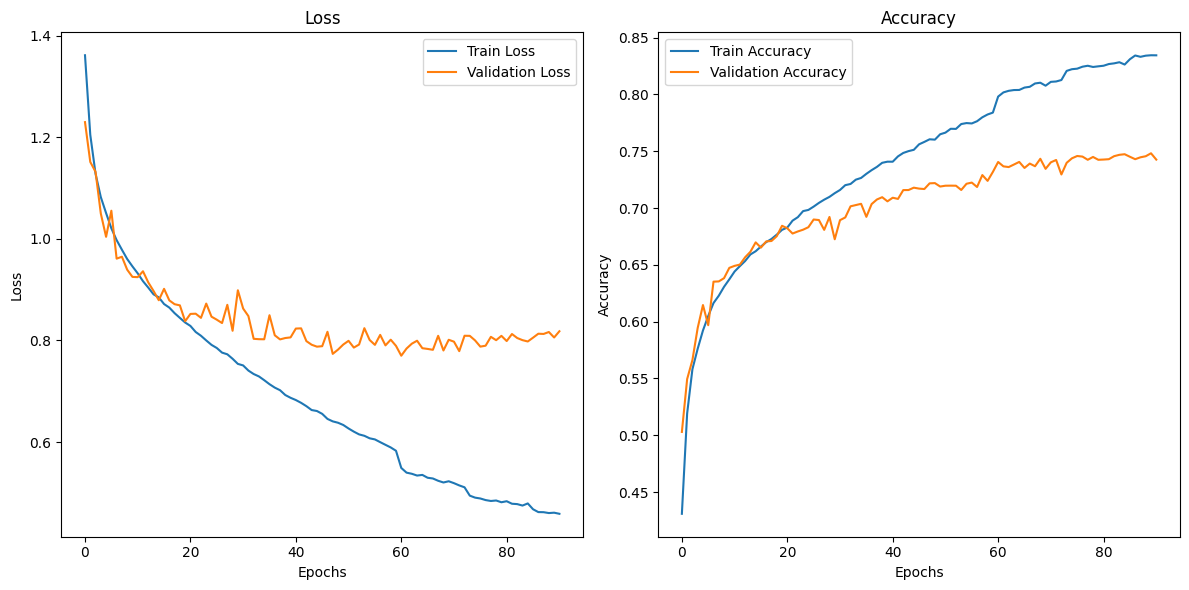

750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Classification Report:
                       precision    recall  f1-score   support

Circumferential Crack       0.63      0.77      0.70      4100
          Gasket Leak       0.54      0.58      0.56      5300
   Longitudinal Crack       0.50      0.49      0.49      4700
              No-leak       0.58      0.54      0.56      5100
         Orifice Leak       0.45      0.38      0.41      4800

             accuracy                           0.55     24000
            macro avg       0.54      0.55      0.54     24000
         weighted avg       0.54      0.55      0.54     24000



NameError: name 'sns' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
# Implementación redimensionada del Vision Transformer para STM32CubeAI
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Capa personalizada para el embedding posicional
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.embedding_dim = embedding_dim
        self.pos_embedding = self.add_weight(
            shape=(sequence_length, embedding_dim),
            initializer="random_normal",
            trainable=True,
            name="positional_embeddings",
        )

    def call(self, inputs):
        return inputs + self.pos_embedding

    def compute_output_shape(self, input_shape):
        return input_shape

# Bloque transformador reutilizable (reducido)
def transformer_block(inputs, embed_dim, num_heads, mlp_dim, dropout_rate=0.1):
    # Layer Norm 1
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-Head Attention (reducido a 4 cabezas)
    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads,
        value_dim=embed_dim // num_heads
    )(x, x)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    x = layers.Add()([inputs, attn_output])

    # Layer Norm 2
    y = layers.LayerNormalization(epsilon=1e-6)(x)

    # MLP Block (reducido a 2x embed_dim)
    mlp = layers.Dense(mlp_dim, kernel_regularizer=regularizers.l2(1e-4))(y)
    mlp = layers.Activation('gelu')(mlp)
    mlp = layers.Dropout(dropout_rate)(mlp)
    mlp = layers.Dense(embed_dim, kernel_regularizer=regularizers.l2(1e-4))(mlp)
    mlp = layers.Dropout(dropout_rate)(mlp)

    return layers.Add()([x, mlp])

# Implementación redimensionada del ViT (target: 150-200KB)
def build_improved_vit(input_shape, num_classes):
    """
    Construye un modelo Vision Transformer ligero optimizado para STM32.
    """
    inputs = keras.Input(shape=input_shape)

    # ETAPA DE EMBEDDING (REDUCIDA)
    # Primera capa convolucional (de 32 a 16 filtros)
    x = layers.Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)

    # Segunda capa convolucional (de 64 a 32 filtros)
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)

    # Calculamos las dimensiones después de las convoluciones
    shape_before_reshape = tf.keras.backend.int_shape(x)
    print(f"Forma antes de reshape: {shape_before_reshape}")

    # Aplanar espacialmente
    token_length = shape_before_reshape[1] * shape_before_reshape[2]
    embed_dim = 64  # Reducido de 128 a 64

    # Aplanar y proyectar
    x = layers.Reshape((token_length, shape_before_reshape[3]))(x)
    x = layers.Dense(embed_dim)(x)

    # Añadir embedding posicional
    x = PositionalEmbedding(sequence_length=token_length, embedding_dim=embed_dim)(x)
    x = layers.Dropout(0.1)(x)

    # ETAPA ENCODER REDUCIDA - 2 bloques en lugar de 3
    for _ in range(2):
        x = transformer_block(
            x,
            embed_dim=embed_dim,
            num_heads=4,  # Reducido de 8 a 4
            mlp_dim=embed_dim * 2,  # Reducido de 4x a 2x
            dropout_rate=0.1
        )

    # ETAPA DE CLASIFICACIÓN (SIMPLIFICADA)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)

    # MLP Head simplificado (una sola capa)
    x = layers.Dense(96, activation='gelu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.2)(x)

    # Clasificación final
    outputs = layers.Dense(num_classes, activation="softmax",
                          kernel_regularizer=regularizers.l2(1e-4))(x)

    model = keras.Model(inputs, outputs)

    # Imprimir resumen del modelo
    model.summary()
    print(f"Número total de parámetros: {model.count_params():,}")

    return model

# Función para estimar el tamaño del modelo en TFLite
def estimate_model_size(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    size_kb = len(tflite_model) / 1024
    print(f"Tamaño estimado del modelo TFLite: {size_kb:.2f} KB")
    return size_kb, tflite_model

# Cargar los datos del dataset ELIS segmentado
x_train, y_train = elis_segmented_dataset['x_train'], elis_segmented_dataset['y_train_onehot']
x_val, y_val = elis_segmented_dataset['x_val'], elis_segmented_dataset['y_val_onehot']
x_test, y_test = elis_segmented_dataset['x_test'], elis_segmented_dataset['y_test_onehot']

# Verificar la forma de los datos
print(f"Forma de los datos de entrenamiento: {x_train.shape}")
print(f"Forma de las etiquetas de entrenamiento: {y_train.shape}")

# Construir el modelo Tiny ViT
input_shape = x_train.shape[1:]  # Forma de entrada de los datos
num_classes = y_train.shape[1]  # Número de clases
tiny_vit_model = build_improved_vit(input_shape, num_classes)
estimate_model_size(tiny_vit_model)

# Compilar el modelo
tiny_vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # Learning rate más bajo para Transformer
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Configurar callbacks
import os
os.makedirs('/content/drive/MyDrive/Tesis/Modelos', exist_ok=True)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=12, min_lr=1e-7),
    ModelCheckpoint(filepath="/content/drive/MyDrive/Tesis/Modelos/tiny_vit_elis_model.keras",
                   save_best_only=True,
                   monitor="val_loss")
]

# Entrenar el modelo
print("Iniciando entrenamiento del Tiny Vision Transformer...")
history = tiny_vit_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=500,
    batch_size=32,  # Batch size más pequeño para Transformer
    callbacks=callbacks
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = tiny_vit_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualizar las métricas de entrenamiento
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Generar reporte de clasificación
y_pred = np.argmax(tiny_vit_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_codes_dict.keys())))

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_codes_dict.keys()), yticklabels=list(label_codes_dict.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Analizar el tamaño del modelo para deployment
print("\n=== Análisis de tamaño para despliegue en STM32 ===")
print(f"Número total de parámetros: {tiny_vit_model.count_params():,}")

# Convertir a TFLite para estimar el tamaño del modelo
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(tiny_vit_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Guardar el modelo TFLite
with open('/content/drive/MyDrive/Tesis/Modelos/tiny_vit_elis_model.tflite', 'wb') as f:
    f.write(tflite_model)

print(f"Tamaño del modelo TFLite: {len(tflite_model) / 1024:.2f} KB")

# Verificar compatibilidad con STM32CubeAI
print("\nEl modelo Tiny Vision Transformer diseñado:")
print("- Reduce dimensionalidad con convoluciones iniciales")
print("- Utiliza un encoder transformer único")
print("- Minimiza parámetros para ajustarse a las restricciones de STM32")
print("- Mantiene regularización para evitar overfitting")